<a href="https://colab.research.google.com/github/antoniovfonseca/summarize-change-components/blob/main/summarize_change_components_westernBahia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.Environment Setup**


---



### **1.1.Install Python Libraries**


In [ ]:
# Run this cell only if you are using Google Colab
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

### **1.2.Importing Libraries**

In [1]:
# Standard library
import glob
import os
import pickle
import sys
import time

# Typing for annotations
from typing import Dict, List, Optional  # NEW

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import math
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker


from pathlib import Path
from numba import prange
from pyproj import Transformer
from pyproj import Geod
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow  # scale_bar removed
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

from typing import Iterable, Tuple

### **1.3.Mounting Google Drive in Colab**



In [ ]:
# Run this cell only if you are using Google Colab
from google.colab import drive
drive.mount("/content/drive")

## **2.Data Preparation**

### **2.1.Setting Paths to Image Files**

The user must include the year in the raster map name.

In [2]:
# List of input raster paths
image_paths = [
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_1990.tif",
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_1995.tif",
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2000.tif",
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2005.tif",
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2010.tif",
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2015.tif",
    r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/lulc_mapbiomas_2020.tif",
]

# Raster mask path
mask_path = r"/mnt/c/Users/AntFonseca//github/1.INPUT/summarize-patterns/WESTERN/WesternBahiaMask.tif"

# Check if all files exist
all_files = image_paths + [mask_path]
missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print("Missing files:")
    for f in missing_files:
        print(" -", f)
else:
    print("All input files found.")

All input files found.


### **2.2.Setting Path to Output Files**

In [3]:
# Output directory path
output_path = r"/mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output2"

# Create folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists:", output_path)

Folder already exists: /mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output2


### **2.3.Setting Years of the Time Intervals**

In [4]:
# Years of input rasters
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]

### **2.4.Setting the classes**

In [5]:
# Class ID, names, and colors
class_labels_dict = {
     0: {"name": "Backgroud",                  "rename": "Background", "color": "#ffffff"},
     4: {"name": "Savanna Formation",          "rename": "Savanna",    "color": "#ff0000"},
    12: {"name": "Grassland",                  "rename": "Grassland",  "color": "#8b0000"},
     3: {"name": "Forest Formation",           "rename": "Forest",     "color": "#ffffcc"},
    33: {"name": "River, Lake and Ocean",      "rename": "Water",      "color": "#ffff99"},
    46: {"name": "Coffee",                     "rename": "Coffee",     "color": "#ffff66"},
    29: {"name": "Rocky Outcrop",              "rename": "Rocky",      "color": "#ffff00"},
    11: {"name": "Wetland",                    "rename": "Wetland",    "color": "#cc9900"},
    24: {"name": "Urban Area",                 "rename": "Urban",      "color": "#ffcccc"},
     9: {"name": "Forest Plantation",          "rename": "Plantation", "color": "#ffcc99"},
    48: {"name": "Other Perennial Crops",      "rename": "Perennial",  "color": "#ffcc66"},
    25: {"name": "Other non Vegetated Areas",  "rename": "Barren",     "color": "#ffcc00"},
    21: {"name": "Mosaic of Uses",             "rename": "Mosaic",     "color": "#ff9900"},
    62: {"name": "Cotton (beta)",              "rename": "Cotton",     "color": "#ff66ff"},
    15: {"name": "Pasture",                    "rename": "Pasture",    "color": "#cc00cc"},
    41: {"name": "Other Temporary Crops",      "rename": "Temporary",  "color": "#0000ff"},
    39: {"name": "Soybean",                    "rename": "Soybean",    "color": "#00bfff"},
}


# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["rename"] for key in sorted(class_labels_dict.keys())]

### **2.4.Apply Mask**

In [ ]:
def apply_mask_to_images(image_paths, output_path, mask_path=None):
    """
    Apply a mask to raster images and save as 8-bit TIFFs.

    Args:
        image_paths (list[str]): Paths to input images.
        output_path (str): Directory to save masked images.
        mask_path (str, optional): Path to mask raster.

    Returns:
        list[str]: Paths to saved masked images.
    """
    # Create output folder if missing
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    saved_paths = []

    # Load mask if provided
    mask_data = None
    if mask_path:
        with rasterio.open(mask_path) as mask_file:
            mask_data = mask_file.read(1)

    # Apply mask to each image
    for path in image_paths:
        with rasterio.open(path) as image:
            meta = image.meta.copy()

            # Force 8-bit TIFF settings
            meta["dtype"] = "uint8"
            meta["nodata"] = 0
            meta["driver"] = "GTiff"
            meta["compress"] = "lzw"

            # Read raster band and apply mask
            image_data = image.read(1)
            if mask_data is not None:
                masked_data = (image_data * (mask_data == 1)).astype("uint8")
            else:
                masked_data = image_data.astype("uint8")

            # Build output path
            base_name = os.path.basename(path).replace(".tif", "_masked.tif")
            masked_path = os.path.join(output_path, base_name)

            # Save masked image
            with rasterio.open(masked_path, "w", **meta) as dest:
                dest.write(masked_data, 1)

            saved_paths.append(masked_path)

    return saved_paths


# Apply mask and save results
masked_image_paths = apply_mask_to_images(image_paths, output_path, mask_path)

# Print saved paths
for path in masked_image_paths:
    print(path)

### **2.5.Display the Maps**

The code defines a function to find files with a given suffix and returns their paths. It then defines a function that plots each raster file with a specified color map, and a legend. It reads the raster data with rasterio, reshapes it, applies the color map, and arranges the images in a single row of subplots. It sets each plot’s title with the provided year, hides the axes, and includes a custom legend. Finally, it saves the plot as a JPEG and displays it.

In [ ]:
def _dx_km_generic_for_display(
    raster_path: str,
    downsample_divisor: int,
) -> float:
    """Return km per displayed pixel for any CRS (geodesic at mid-lat)."""
    with rasterio.open(raster_path) as src:
        left, bottom, right, top = src.bounds
        lat_mid_src = (top + bottom) / 2.0

        to_ll = Transformer.from_crs(
            src.crs,
            "EPSG:4326",
            always_xy=True,
        )
        lon_l, lat_mid = to_ll.transform(
            left,
            lat_mid_src,
        )
        lon_r, _ = to_ll.transform(
            right,
            lat_mid_src,
        )

        geod = Geod(ellps="WGS84")
        _, _, width_m = geod.inv(
            lon_l,
            lat_mid,
            lon_r,
            lat_mid,
        )

        cols_disp = max(
            1,
            src.width // downsample_divisor,
        )
        return (width_m / cols_disp) / 1_000  # km/pixel


def plot_classified_images(
    # image_paths: List[str],
    class_map: Dict[int, Dict[str, str]],
    years: List[int],
    output_path: str,
    downsample_divisor: int = 2,             # display downsample
    panel_size: tuple = (4.0, 6.0),          # width, height per panel (inches)
    dx_km: Optional[float] = None,           # km/pixel (auto if None)
    resampling_method: Resampling = Resampling.bilinear,
) -> None:

    image_paths = sorted(glob.glob(os.path.join(output_path, "*masked.tif")))

    """Plot classified rasters with legend, north arrow, and km scale bar."""
    if not image_paths:
        raise ValueError("image_paths is empty.")
    if len(image_paths) != len(years):
        raise ValueError("image_paths and years must match in length.")

    # Figure
    n_images = len(image_paths)
    ncols = min(4, n_images)  # max 4 columns
    nrows = math.ceil(n_images / ncols)
    fig, axs = plt.subplots(
        1,
        n_images,
        figsize=(panel_size[0] * n_images, panel_size[1]),
        sharey=True,
        constrained_layout=False,
    )
    plt.subplots_adjust(
        left=0.02,
        right=0.85,
        top=0.95,
        bottom=0.05,
        wspace=0.04,
    )

    # Colormap and norm
    class_ids_sorted = sorted(class_map.keys())
    cmap = ListedColormap(
        [class_map[k]["color"] for k in class_ids_sorted]
    )
    norm = BoundaryNorm(
        class_ids_sorted + [class_ids_sorted[-1] + 1],
        cmap.N,
    )

    # Km per displayed pixel
    if dx_km is None:
        dx_km = _dx_km_generic_for_display(
            image_paths[0],
            downsample_divisor,
        )

    # Plot rasters
    axes = axs if n_images > 1 else [axs]
    for i, (path, ax) in enumerate(zip(image_paths, axes)):
        with rasterio.open(path) as src:
            h = max(1, src.height // downsample_divisor)
            w = max(1, src.width // downsample_divisor)
            data = src.read(
                1,
                out_shape=(h, w),
                resampling=resampling_method,
            )
        ax.imshow(
            data,
            cmap=cmap,
            norm=norm,
        )
        ax.set_title(
            f"{years[i]}",
            fontweight="bold",
        )
        ax.axis("off")

    # Legend (exclude id 0)
    legend_ids = [k for k in class_map.keys() if k != 0]
    # legend_ids = sorted(class_map.keys())
    legend_elements = [
        Rectangle(
            (0, 0),
            1,
            1,
            color=class_map[k]["color"],
            label=class_map[k]["name"],
        )
        for k in legend_ids
    ]
    row_anchor = 0.5  # vertical center
    col_anchor = 0.95  # adjust horizontal spacing
    fig.legend(
        handles=legend_elements,
        loc="center right",
        bbox_to_anchor=(col_anchor, row_anchor),
        frameon=False,
    )

    # Scale bar (km)
    scalebar = ScaleBar(
        dx=dx_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        scale_loc="bottom",
        color="black",
        box_alpha=0,
    )
    axes[-1].add_artist(
        scalebar
    )

    # North arrow
    north_arrow(
        axes[-1],
        location="upper right",
        shadow=False,
        rotation={"degrees": 0},
    )

    # Save
    out_fig = os.path.join(
        output_path,
        "plot_input_maps2.jpeg",
    )
    plt.savefig(
        out_fig,
        format="jpeg",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
    plt.close()


# Call
plot_classified_images(
    # masked_image_paths,
    class_labels_dict,
    years,
    output_path,
)

## **2.6 Class distribution over time**

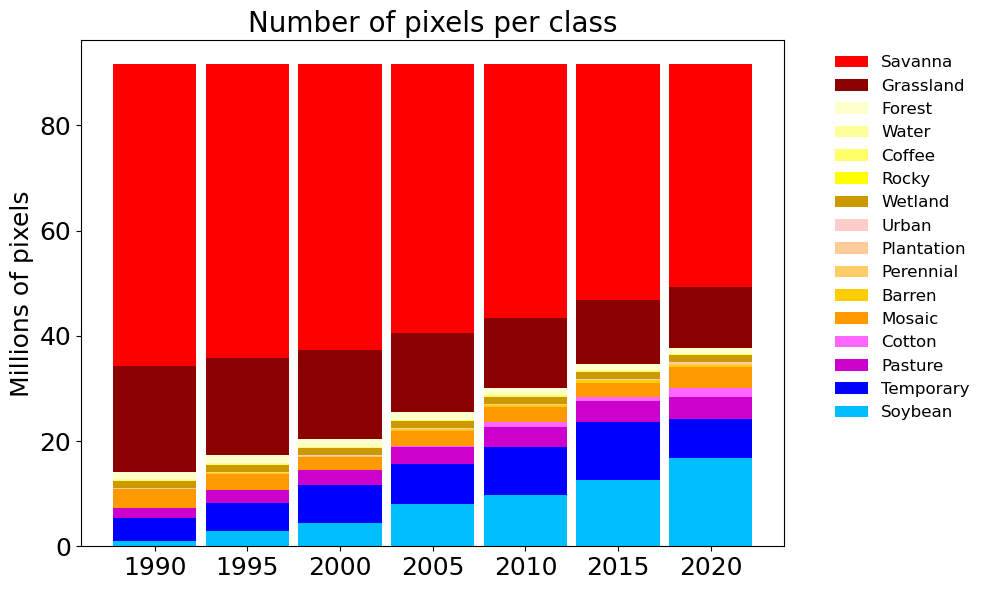

In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

image_paths = sorted(
    glob.glob(
        os.path.join(
            output_path,
            "*masked.tif",
        ),
    ),
)

if len(image_paths) != len(years):
    raise ValueError(
        f"Found {len(image_paths)} masked rasters but len(years) == {len(years)}.",
    )

records: list[dict] = []

# Count pixels per class (excluding 0 / Background) for each year
for year, path in zip(
    years,
    image_paths,
):
    with rasterio.open(path) as src:
        data = src.read(1)

    values, counts = np.unique(
        data,
        return_counts=True,
    )

    for v, c in zip(
        values,
        counts,
    ):
        v = int(v)
        if v == 0:
            continue  # skip 0 / Background
        if v not in class_labels_dict:
            continue

        records.append(
            {
                "Year": year,
                "ClassID": v,
                "ClassName": class_labels_dict[v]["rename"],
                "Pixels": int(c),
            },
        )

df_pixels = pd.DataFrame(records)

# Pivot table: rows = years, columns = classes, values = pixel counts
pivot_pixels = (
    df_pixels.pivot_table(
        index="Year",
        columns="ClassName",
        values="Pixels",
        aggfunc="sum",
    )
    .fillna(0.0)
    .astype(float)
)

# Convert to millions of pixels
pivot_pixels_millions = pivot_pixels / 1e6

# Class IDs and color map (without 0)
class_ids_plot = [
    k
    for k in sorted(class_labels_dict.keys())
    if k != 0
]
color_map = {
    class_labels_dict[k]["rename"]: class_labels_dict[k]["color"]
    for k in class_ids_plot
}

# Sort classes by net change (last - first): losers at top, gainers at bottom
# Sort classes by net change (last - first)
years_array = pivot_pixels_millions.index.values
first_year = years_array[0]
last_year = years_array[-1]

net_change_per_class = (
    pivot_pixels_millions.loc[last_year]
    - pivot_pixels_millions.loc[first_year]
)

# Order for stacking:
#   bottom = largest gainers, top = largest losers
classes_for_stack = list(
    net_change_per_class.sort_values(
        ascending=False,
    ).index,
)

# Order for legend:
#   top = largest losers, bottom = largest gainers
classes_for_legend = list(reversed(classes_for_stack))

# Stacked bar chart
fig, ax = plt.subplots(
    figsize=(
        10,
        6,
    ),
)

x = np.arange(len(years_array))
width = 0.9

base = np.zeros(
    len(years_array),
    dtype=float,
)

patches_by_class: dict[str, plt.Artist] = {}

for cls in classes_for_stack:
    if cls not in pivot_pixels_millions.columns:
        continue

    values_cls = pivot_pixels_millions[cls].reindex(
        years_array,
        fill_value=0.0,
    ).values

    bars = ax.bar(
        x,
        values_cls,
        bottom=base,
        width=width,
        label=cls,
        color=color_map[cls],
    )
    # keep one handle per class for the legend
    patches_by_class[cls] = bars[0]
    base += values_cls

ax.set_xticks(x)
ax.set_xticklabels(
    years_array,
    rotation=0,
)
ax.tick_params(
    axis="both",
    labelsize=18,
)

ax.set_ylabel(
    "Millions of pixels",
    fontsize=18,
)
ax.set_title(
    "Number of pixels per class",
    fontsize=20,
)

# Legend: largest losers at the top, largest gainers at the bottom
handles = [
    patches_by_class[cls]
    for cls in classes_for_legend
    if cls in patches_by_class
]
labels = [
    cls
    for cls in classes_for_legend
    if cls in patches_by_class
]

ax.legend(
    handles,
    labels,
    bbox_to_anchor=(
        1.05,
        1.0,
    ),
    loc="upper left",
    frameon=False,
    fontsize=12,
)

plt.tight_layout()
plt.show()


## **3.Generate the Transition Matrix**


---
In this section, the computer code will generate four different transition matrices. The first one is related to each time interval. The second one is the transition matrix for the temporal extent, which is represented for the first and last time point of the time extent. The third one is a transition matrix that represents the sum of all time intervals. And the last transition matrix is the alternation matrix, which is the sum matrix minus the extent matrix.

Before generate the transition matrix, the computer code will analyze the presence of 0, NULL and NA value in all maps. If there is a presence of one of these values, the computer code will create a mask with these values and will remove all the pixels in the same position in all maps and years.

All the transition matrix will be salved in the Google Drive in the ".csv" format.

In [ ]:
# Generate the Transition Matrix
def generate_mask_and_flatten_rasters(
    output_path: str,
    suffix: str = "_masked.tif",
) -> List[np.ndarray]:
    """
    Read rasters by suffix, mask zeros/NaN/nodata, and flatten valid values.

    Args:
        output_path: Folder containing rasters.
        suffix: Filename suffix to select rasters.

    Returns:
        List of flattened arrays (one per raster).
    """
    # Collect and sort raster paths
    image_paths = [
        os.path.join(output_path, f)
        for f in os.listdir(output_path)
        if f.endswith(suffix)
    ]
    image_paths.sort()

    all_data: List[np.ndarray] = []
    all_masks: List[np.ndarray] = []

    # Read and mask rasters
    for path in image_paths:
        with rasterio.open(path) as src:
            data = src.read(1)
            mask = (data == 0) | (data == src.nodata) | np.isnan(data)
            all_masks.append(mask)
            all_data.append(data)

    # Union of masks
    combined_mask = np.any(all_masks, axis=0)

    # Flatten non-masked values
    flattened = [
        data[~combined_mask].flatten() if np.any(combined_mask) else data.flatten()
        for data in all_data
    ]
    return flattened


# Alias for readability
transition_matrix = confusion_matrix


def generate_all_matrices(
    output_path: str,
    suffix: str = "_masked.tif",
) -> tuple[list[int], np.ndarray]:
    """Generate interval, extent, sum, and alternation matrices and save CSVs."""
    global years  # uses the global list of years

    # Load processed data
    flattened_data = generate_mask_and_flatten_rasters(output_path, suffix)

    # Validate year count
    if len(years) != len(flattened_data):
        raise ValueError(
            f"Mismatch: {len(years)} years vs {len(flattened_data)} rasters"
        )

    # All classes present
    all_classes = np.unique(np.concatenate(flattened_data)).astype(int)

    # Interval matrices
    for i in range(len(flattened_data) - 1):
        cm = transition_matrix(
            flattened_data[i],
            flattened_data[i + 1],
            labels=all_classes,
        )
        out_csv = os.path.join(
            output_path,
            f"transition_matrix_{years[i]}-{years[i+1]}.csv",
        )
        pd.DataFrame(
            cm,
            index=all_classes,
            columns=all_classes,
        ).to_csv(out_csv)

    # Extent matrix
    extent_matrix = transition_matrix(
        flattened_data[0],
        flattened_data[-1],
        labels=all_classes,
    )
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_extent_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        extent_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    # Sum of interval matrices
    n = len(all_classes)
    sum_matrix = np.zeros((n, n), dtype=int)
    for i in range(len(flattened_data) - 1):
        sum_matrix += transition_matrix(
            flattened_data[i],
            flattened_data[i + 1],
            labels=all_classes,
        )
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_sum_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        sum_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    # Alternation matrix
    alternation_matrix = sum_matrix - extent_matrix
    out_csv = os.path.join(
        output_path,
        f"transition_matrix_alternation_{years[0]}-{years[-1]}.csv",
    )
    pd.DataFrame(
        alternation_matrix,
        index=all_classes,
        columns=all_classes,
    ).to_csv(out_csv)

    return years, all_classes


def main(output_path: str) -> None:
    """Matrix generation workflow."""
    # Ensure output folder exists
    os.makedirs(output_path, exist_ok=True)

    # Build all matrices
    print("Generating transition matrices...")
    years_out, all_classes = generate_all_matrices(output_path)

    print(f"Detected classes: {all_classes}")
    print("Matrices saved in:", output_path)


if __name__ == "__main__":
    main(output_path)

## **3.1 Heat maps of the transition matrices**

In [ ]:
# Basic checks
assert isinstance(years, (list, tuple)) and len(years) >= 2, "`years` missing or invalid."
assert isinstance(output_path, str) and output_path, "`output_path` missing or invalid."
assert isinstance(class_labels_dict, dict) and class_labels_dict, "`class_labels_dict` missing or invalid."

Y0, Y1 = years[0], years[-1]
OUT_DIR = Path(output_path)

CSV_SUM = OUT_DIR / f"transition_matrix_sum_{Y0}-{Y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{Y0}-{Y1}.csv"
CSV_ALT = OUT_DIR / f"transition_matrix_alternation_{Y0}-{Y1}.csv"
CSV_EXC = OUT_DIR / f"transition_matrix_exchange_FROM_SUM_{Y0}-{Y1}.csv"

for p in (CSV_SUM, CSV_EXT, CSV_ALT):
    if not p.exists():
        raise FileNotFoundError(f"Missing CSV: {p}")
print("Found base CSVs.")

In [ ]:
def load_square_matrix(csv_path: Path) -> pd.DataFrame:
    """
    Load a square transition matrix T with labels on rows and columns.
    Align rows and columns by union when they differ; fill missing with zeros.
    Keep labels as strings to preserve class IDs.
    """
    df = pd.read_csv(csv_path, index_col=0)
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)
    if list(df.index) != list(df.columns):
        labels = sorted(set(df.index).union(df.columns), key=lambda x: int(x))
        df = df.reindex(index=labels, columns=labels).fillna(0.0)
    if df.shape[0] != df.shape[1]:
        raise ValueError(f"Matrix not square after alignment: {csv_path}")
    return df


def label_id_to_name(labels: Iterable[str]) -> list[str]:
    """
    Map class IDs (as strings) to human-readable names using class_labels_dict.
    Fall back to the original ID string when missing.
    """
    id_to_name = {
        int(k): v.get("rename", v.get("name", str(k)))
        for k, v in class_labels_dict.items()
    }
    names = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(id_to_name.get(cid, str(lab)))
        except Exception:
            names.append(str(lab))
    return names


def exchange_from_T(dfT: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the exchange matrix from a transition matrix T:
    E(i,j) = min(Tij, Tji) for i != j; E(i,i) = 0.
    """
    T = dfT.values.astype(float)
    E = np.minimum(T, T.T)
    np.fill_diagonal(E, 0.0)
    return pd.DataFrame(E, index=dfT.index, columns=dfT.columns)


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
    factor: float = 1.0,
) -> None:
    """
    Write per-cell values as integers (no decimals), scaled by `factor`.
    """
    if M.size == 0:
        return
    mmax = float(np.nanmax(M))
    thresh = 0.5 * mmax if mmax > 0 else 0.0

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            v_scaled = v / factor       # <-- escala aqui
            txt = f"{int(round(v_scaled))}"
            color = "white" if v >= thresh else "black"
            ax.text(
                j, i, txt,
                ha="center", va="center",
                fontsize=fontsize, color=color, clip_on=True
            )

def _unit_label(suffix: str, base_label: str = "Number of pixels") -> str:
    """
    Convert unit suffix to a descriptive label for the colorbar.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }
    return mapping.get(suffix, f"{base_label} ({suffix})")


def _auto_unit(
    vmax: float,
    base: int = 1000,
    units=("", "k", "M", "B", "T", "P"),  # plain tuple, no type from typing
) -> Tuple[float, str]:
    """
    Pick the largest unit so that vmax / factor is in [1, base).
    Returns (factor, suffix). For vmax <= 0, returns (1.0, "").
    """
    if not np.isfinite(vmax) or vmax <= 0:
        return 1.0, ""
    exp = int(np.floor(np.log(vmax) / np.log(base)))
    exp = max(0, min(exp, len(units) - 1))
    return float(base**exp), units[exp]


def _unit_formatter(factor: float, suffix: str, decimals: int = 1) -> mticker.FuncFormatter:
    """Build a FuncFormatter that scales ticks by `factor` and appends `suffix`."""
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(x, pos):
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


# %% [code]
# Color scaling utilities: linear / log / power + optional percentile clipping
def _compute_vlimits(M: np.ndarray, vmin: float | None, vmax: float | None,
                     vmax_percentile: float | None) -> tuple[float, float]:
    """
    Compute vmin/vmax with optional upper-percentile clipping to reduce the effect
    of extreme outliers (e.g., 99.5 -> clip the top 0.5%).
    """
    data = M[np.isfinite(M)]
    lo = float(np.nanmin(data)) if vmin is None else float(vmin)
    if vmax_percentile is not None:
        hi = float(np.nanpercentile(data, vmax_percentile))
    else:
        hi = float(np.nanmax(data)) if vmax is None else float(vmax)
    if hi <= lo:
        hi = lo + 1.0
    return lo, hi


def _make_norm(scale: str, vmin: float, vmax: float, gamma: float = 0.5) -> mcolors.Normalize:
    """
    Build a Matplotlib normalization:
      - 'linear' (default): mcolors.Normalize
      - 'log':     mcolors.LogNorm (values must be > 0)
      - 'power':   mcolors.PowerNorm(gamma)
    """
    scale = scale.lower()
    if scale == "log":
        # ensure strictly positive range for LogNorm
        vmin_eff = max(vmin, 1e-9)
        return mcolors.LogNorm(vmin=vmin_eff, vmax=vmax)
    if scale == "power":
        return mcolors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
    return mcolors.Normalize(vmin=vmin, vmax=vmax)

# Plot with thin colorbar, integer annotations, and automatic unit label (k/M/B/T

def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int = 8,
    ann_fontsize: int = 8,
    cbar_scale: str = "auto",       # {"auto","k","M","B","T","none"}
    cbar_base: int = 1000,
    cbar_decimals: int = 1,
    cbar_nticks: int = 6,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix with integer annotations and auto-scaled colorbar.
    Now supports independent font sizes for X/Y class names via
    `tick_fontsize_x` and `tick_fontsize_y`.
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError("Set tick_fontsize_x and tick_fontsize_y explicitly in the call.")
    if axis_label_fontsize is None:
        axis_label_fontsize = 12
    if title_fontsize is None:
        title_fontsize = 14

    labels = list(df.index)
    M = df.values.astype(float)
    vmax_eff = float(np.nanmax(M)) if vmax is None else float(vmax)

    # Figure size from number of cells
    nrows, ncols = df.shape
    if figsize is None:
        figsize = (cell_size_inch * ncols, cell_size_inch * nrows)

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    im = ax.imshow(M, aspect="equal", cmap=cmap, vmin=vmin, vmax=vmax_eff)

    # Ticks and class names
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    # Fallback to `tick_fontsize` if provided
    fx = tick_fontsize if tick_fontsize is not None else tick_fontsize_x
    fy = tick_fontsize if tick_fontsize is not None else tick_fontsize_y

    ax.set_xticklabels(tick_names, rotation=rotate_xticks_deg, fontsize=fx)
    ax.set_yticklabels(tick_names, fontsize=fy)

    ax.set_xlabel("To class", fontsize=axis_label_fontsize)
    ax.set_ylabel("From class", fontsize=axis_label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Colorbar with automatic units
    cbar = plt.colorbar(im, ax=ax, fraction=cbar_fraction, pad=cbar_pad)
    if cbar_scale == "none":
        factor, suffix = 1.0, ""
    elif cbar_scale in {"k", "M", "B", "T"}:
        order_map = {"": 0, "k": 1, "M": 2, "B": 3, "T": 4}
        factor = float(cbar_base ** order_map[cbar_scale])
        suffix = cbar_scale
    else:
        factor, suffix = _auto_unit(vmax_eff, base=cbar_base)

    cbar.formatter = _unit_formatter(factor, "", decimals=0)
    cbar.locator = mticker.MaxNLocator(nbins=cbar_nticks)
    cbar.update_normal(im)
    cbar.set_label(_unit_label(suffix), rotation=270, labelpad=14)

    if annotate:
        annotate_heatmap(ax, M, fontsize=ann_fontsize, factor=factor)

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
# Load SUM/EXT/ALT, compute EXCHANGE, and save CSV

df_sum = load_square_matrix(CSV_SUM)
df_ext = load_square_matrix(CSV_EXT)
df_alt = load_square_matrix(CSV_ALT)

df_exc = exchange_from_T(df_sum)
df_exc.to_csv(CSV_EXC, index=True)
print("Saved EXCHANGE matrix to:", CSV_EXC)

In [ ]:
# Paths for figures
FIG_SUM = OUT_DIR / f"heatmap_SUM_{Y0}-{Y1}.png"
FIG_EXT = OUT_DIR / f"heatmap_EXTENT_{Y0}-{Y1}.png"
FIG_ALT = OUT_DIR / f"heatmap_ALTERNATION_{Y0}-{Y1}.png"
FIG_EXC = OUT_DIR / f"heatmap_EXCHANGE_FROM_SUM_{Y0}-{Y1}.png"

# Re-plot with larger class-name labels on both axes

for df, title, path in [
    (df_sum, f"Sum of all annual time intervals {Y0}-{Y1}", OUT_DIR / f"heatmap_SUM_{Y0}-{Y1}.png"),
    (df_ext, f"Extent matrix {Y0}-{Y1}", OUT_DIR / f"heatmap_EXTENT_{Y0}-{Y1}.png"),
    (df_alt, f"Alternation matrix {Y0}-{Y1}", OUT_DIR / f"heatmap_ALTERNATION_{Y0}-{Y1}.png"),
    (df_exc, f"Sum Exchange {Y0}-{Y1}", OUT_DIR / f"heatmap_EXCHANGE_FROM_SUM_{Y0}-{Y1}.png"),
]:
    plot_heatmap(
        df,
        title=title,
        save_path=path,
        tick_fontsize=None,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_scale="auto",
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )


### Heat Maps Beta

#### Heat map adjusted

In [ ]:
# %% [code]
from __future__ import annotations

from pathlib import Path
from typing import Iterable
from typing import Tuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

# Basic checks
assert isinstance(
    years,
    (list, tuple),
) and len(years) >= 2, "`years` missing or invalid."
assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."
assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."

Y0, Y1 = years[0], years[-1]
OUT_DIR = Path(output_path)

CSV_SUM = OUT_DIR / f"transition_matrix_sum_{Y0}-{Y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{Y0}-{Y1}.csv"
CSV_ALT = OUT_DIR / f"transition_matrix_alternation_{Y0}-{Y1}.csv"
CSV_EXC = OUT_DIR / f"transition_matrix_exchange_FROM_SUM_{Y0}-{Y1}.csv"

for p in (
    CSV_SUM,
    CSV_EXT,
    CSV_ALT,
):
    if not p.exists():
        raise FileNotFoundError(
            f"Missing CSV: {p}",
        )
print("Found base CSVs.")


def load_square_matrix(
    csv_path: Path,
) -> pd.DataFrame:
    """
    Load a square transition matrix T with labels on rows and columns.
    Align rows and columns by union when they differ; fill missing with zeros.
    Keep labels as strings to preserve class IDs.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )
    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class IDs (as strings) to human-readable names using class_labels_dict.
    Fall back to the original ID string when missing.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))
    return names


def exchange_from_T(
    dfT: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compute the exchange matrix from a transition matrix T:
    E(i,j) = min(Tij, Tji) for i != j; E(i,i) = 0.
    """
    T = dfT.values.astype(float)
    E = np.minimum(
        T,
        T.T,
    )
    np.fill_diagonal(
        E,
        0.0,
    )
    return pd.DataFrame(
        E,
        index=dfT.index,
        columns=dfT.columns,
    )


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Write per-cell values as integers (no decimals),
    using the original (unscaled) matrix values.
    """
    if M.size == 0:
        return

    mmax = float(np.nanmax(M))
    thresh = 0.5 * mmax if mmax > 0 else 0.0

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            txt = f"{int(round(v))}"
            color = "white" if v >= thresh else "black"
            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )


def _unit_label(
    suffix: str,
    base_label: str = "Number of pixels",
) -> str:
    """
    Convert unit suffix to a descriptive label for the colorbar.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }
    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a FuncFormatter that scales ticks by `factor`
    and appends `suffix`.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x,
        pos,
    ):
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def _compute_vlimits(
    M: np.ndarray,
    vmin: float | None,
    vmax: float | None,
    vmax_percentile: float | None,
) -> tuple[float, float]:
    """
    Compute vmin/vmax with optional upper-percentile clipping to reduce
    the effect of extreme outliers (e.g., 99.5 -> clip the top 0.5%).
    """
    data = M[np.isfinite(M)]
    lo = float(np.nanmin(data)) if vmin is None else float(vmin)

    if vmax_percentile is not None:
        hi = float(np.nanpercentile(data, vmax_percentile))
    else:
        hi = float(np.nanmax(data)) if vmax is None else float(vmax)

    if hi <= lo:
        hi = lo + 1.0
    return lo, hi


def _make_norm(
    scale: str,
    vmin: float,
    vmax: float,
    gamma: float = 0.5,
) -> mcolors.Normalize:
    """
    Build a Matplotlib normalization:
      - 'linear' (default): mcolors.Normalize
      - 'log':     mcolors.LogNorm (values must be > 0)
      - 'power':   mcolors.PowerNorm(gamma)
    """
    scale = scale.lower()

    if scale == "log":
        vmin_eff = max(
            vmin,
            1e-9,
        )
        return mcolors.LogNorm(
            vmin=vmin_eff,
            vmax=vmax,
        )

    if scale == "power":
        return mcolors.PowerNorm(
            gamma=gamma,
            vmin=vmin,
            vmax=vmax,
        )

    return mcolors.Normalize(
        vmin=vmin,
        vmax=vmax,
    )
def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int | None = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix with integer annotations.

    Colorbar is always labeled in millions of pixels (M).
    Cell annotations show integer pixel counts (no scaling).

    Regra de cores:
      - valores < 0  -> tons de azul (mais negativo -> azul mais escuro);
      - valores >= 0 -> tons de YlOrRd (amarelo -> vermelho);
      - zero usa a cor inicial da paleta YlOrRd.
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set tick_fontsize_x and tick_fontsize_y explicitly in the call.",
        )
    if axis_label_fontsize is None:
        axis_label_fontsize = 12
    if title_fontsize is None:
        title_fontsize = 14

    labels = list(df.index)
    M = df.values.astype(float)

    has_negative = float(np.nanmin(M)) < 0.0

    if has_negative:
        vmin_eff = float(np.nanmin(M))
        vmax_eff = float(np.nanmax(M))
        if vmin_eff == vmax_eff:
            vmax_eff = vmin_eff + 1.0
    else:
        vmax_eff = float(np.nanmax(M)) if vmax is None else float(vmax)
        vmin_eff = vmin

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # --- Camadas de cores -------------------------------------------------
    if has_negative:
        # camada positiva (>= 0): YlOrRd
        M_pos = np.where(
            M < 0.0,
            0.0,
            M,
        )
        norm_pos = mcolors.Normalize(
            vmin=0.0,
            vmax=vmax_eff,
        )
        im_pos = ax.imshow(
            M_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

        # camada negativa (< 0): Blues_r (mais negativo -> mais escuro)
        M_neg = np.ma.masked_where(
            M >= 0.0,
            M,
        )
        norm_neg = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=0.0,
        )
        ax.imshow(
            M_neg,
            aspect="equal",
            cmap=plt.cm.Blues_r,  # <--- ordem revertida
            norm=norm_neg,
        )

        main_for_cbar = im_pos
    else:
        norm_pos = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=vmax_eff,
        )
        im_pos = ax.imshow(
            M,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        main_for_cbar = im_pos

    # --- Ticks, labels e títulos ------------------------------------------
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    fx = tick_fontsize if tick_fontsize is not None else tick_fontsize_x
    fy = tick_fontsize if tick_fontsize is not None else tick_fontsize_y

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=fx,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=fy,
    )

    ax.set_xlabel(
        "To class",
        fontsize=axis_label_fontsize,
    )
    ax.set_ylabel(
        "From class",
        fontsize=axis_label_fontsize,
    )
    ax.set_title(
        title,
        fontsize=title_fontsize,
    )

    # --- Colorbar personalizada (sempre min..max em milhões) --------------
    n_bar = 256
    vals = np.linspace(
        vmin_eff,
        vmax_eff,
        n_bar,
    )
    colors_bar = np.zeros(
        (n_bar, 4),
        dtype=float,
    )

    for i, v in enumerate(vals):
        if has_negative and v < 0.0:
            # v em [vmin,0] -> [0,1] em Blues_r (mais negativo -> mais escuro)
            t = (v - vmin_eff) / (0.0 - vmin_eff)
            colors_bar[i, :] = plt.cm.Blues_r(t)
        else:
            # v em [0,vmax] -> [0,1] em YlOrRd
            if vmax_eff > 0:
                t = max(0.0, v) / vmax_eff
            else:
                t = 0.0
            colors_bar[i, :] = plt.cm.YlOrRd(t)

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(
        vmin=vmin_eff,
        vmax=vmax_eff,
    )

    sm = plt.cm.ScalarMappable(
        cmap=cmap_bar,
        norm=norm_bar,
    )
    sm.set_array([])

    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    # Colorbar em milhões de pixels
    factor = 1_000_000.0
    suffix = "M"

    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    locator = mticker.MaxNLocator(
        nbins=7 if has_negative else 6,
    )
    ticks_pixels = locator.tick_values(
        vmin_eff,
        vmax_eff,
    )
    cbar.set_ticks(ticks_pixels)
    cbar.update_normal(sm)
    cbar.set_label(
        _unit_label(suffix),
        rotation=270,
        labelpad=14,
    )

    # --- Anotações inteiras -----------------------------------------------
    if annotate:
        annotate_heatmap(
            ax=ax,
            M=M,
            fontsize=ann_fontsize,
        )

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()


#### Black diagonal heat map

In [ ]:
# %% [code]
from __future__ import annotations

from pathlib import Path
from typing import Iterable
from typing import Tuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

# Basic checks
assert isinstance(
    years,
    (list, tuple),
) and len(years) >= 2, "`years` missing or invalid."
assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."
assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."

Y0, Y1 = years[0], years[-1]
OUT_DIR = Path(output_path)

CSV_SUM = OUT_DIR / f"transition_matrix_sum_{Y0}-{Y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{Y0}-{Y1}.csv"
CSV_ALT = OUT_DIR / f"transition_matrix_alternation_{Y0}-{Y1}.csv"
CSV_EXC = OUT_DIR / f"transition_matrix_exchange_FROM_SUM_{Y0}-{Y1}.csv"

for p in (
    CSV_SUM,
    CSV_EXT,
    CSV_ALT,
):
    if not p.exists():
        raise FileNotFoundError(
            f"Missing CSV: {p}",
        )
print("Found base CSVs.")


def load_square_matrix(
    csv_path: Path,
) -> pd.DataFrame:
    """
    Load a square transition matrix T with labels on rows and columns.
    Align rows and columns by union when they differ; fill missing with zeros.
    Keep labels as strings to preserve class IDs.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )
    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class IDs (as strings) to human-readable names using class_labels_dict.
    Fall back to the original ID string when missing.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))
    return names


def exchange_from_T(
    dfT: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compute the exchange matrix from a transition matrix T:
    E(i,j) = min(Tij, Tji) for i != j; E(i,i) = 0.
    """
    T = dfT.values.astype(float)
    E = np.minimum(
        T,
        T.T,
    )
    np.fill_diagonal(
        E,
        0.0,
    )
    return pd.DataFrame(
        E,
        index=dfT.index,
        columns=dfT.columns,
    )


def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Write per-cell values as integers (no decimals),
    using the original (unscaled) matrix values.

    Diagonal cells are always annotated in white to be
    readable over the black diagonal fill.

    High-magnitude positives (dark red) and
    high-magnitude negatives (dark blue) also use white text.
    """
    if M.size == 0:
        return

    # thresholds for dark red (large positive) and dark blue (large negative)
    data = M[np.isfinite(M)]

    has_pos = np.any(data > 0)
    has_neg = np.any(data < 0)

    max_pos = float(np.nanmax(data[data > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data[data < 0])) if has_neg else 0.0  # most negative

    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf  # e.g., -1.5M if min_neg=-3M

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                # diagonal: always white text on black cell
                color = "white"
            else:
                if (has_pos and v >= thresh_pos) or (has_neg and v <= thresh_neg):
                    # dark red or dark blue cell
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )



def _unit_label(
    suffix: str,
    base_label: str = "Number of pixels",
) -> str:
    """
    Convert unit suffix to a descriptive label for the colorbar.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }
    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a FuncFormatter that scales ticks by `factor`
    and appends `suffix`.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x,
        pos,
    ):
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def _compute_vlimits(
    M: np.ndarray,
    vmin: float | None,
    vmax: float | None,
    vmax_percentile: float | None,
) -> tuple[float, float]:
    """
    Compute vmin/vmax with optional upper-percentile clipping to reduce
    the effect of extreme outliers (e.g., 99.5 -> clip the top 0.5%).
    """
    data = M[np.isfinite(M)]
    lo = float(np.nanmin(data)) if vmin is None else float(vmin)

    if vmax_percentile is not None:
        hi = float(np.nanpercentile(data, vmax_percentile))
    else:
        hi = float(np.nanmax(data)) if vmax is None else float(vmax)

    if hi <= lo:
        hi = lo + 1.0
    return lo, hi


def _make_norm(
    scale: str,
    vmin: float,
    vmax: float,
    gamma: float = 0.5,
) -> mcolors.Normalize:
    """
    Build a Matplotlib normalization:
      - 'linear' (default): mcolors.Normalize
      - 'log':     mcolors.LogNorm (values must be > 0)
      - 'power':   mcolors.PowerNorm(gamma)
    """
    scale = scale.lower()

    if scale == "log":
        vmin_eff = max(
            vmin,
            1e-9,
        )
        return mcolors.LogNorm(
            vmin=vmin_eff,
            vmax=vmax,
        )

    if scale == "power":
        return mcolors.PowerNorm(
            gamma=gamma,
            vmin=vmin,
            vmax=vmax,
        )

    return mcolors.Normalize(
        vmin=vmin,
        vmax=vmax,
    )
def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int | None = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix with integer annotations.

    Colorbar is always labeled in millions of pixels (M).
    Cell annotations show integer pixel counts (no scaling).

    Colors:
      - values < 0  -> blue tones (more negative -> darker blue);
      - values >= 0 -> YlOrRd (yellow -> red);
      - diagonal cells are always filled in black.
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set tick_fontsize_x and tick_fontsize_y explicitly in the call.",
        )
    if axis_label_fontsize is None:
        axis_label_fontsize = 12
    if title_fontsize is None:
        title_fontsize = 14

    labels = list(df.index)
    M = df.values.astype(float)

    has_negative = float(np.nanmin(M)) < 0.0

    if has_negative:
        vmin_eff = float(np.nanmin(M))
        vmax_eff = float(np.nanmax(M))
        if vmin_eff == vmax_eff:
            vmax_eff = vmin_eff + 1.0
    else:
        vmax_eff = float(np.nanmax(M)) if vmax is None else float(vmax)
        vmin_eff = vmin

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # --- color layers ------------------------------------------------------
    if has_negative:
        # positive layer (>= 0): YlOrRd
        M_pos = np.where(
            M < 0.0,
            0.0,
            M,
        )
        norm_pos = mcolors.Normalize(
            vmin=0.0,
            vmax=vmax_eff,
        )
        im_pos = ax.imshow(
            M_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

        # negative layer (< 0): Blues_r (more negative -> darker)
        M_neg = np.ma.masked_where(
            M >= 0.0,
            M,
        )
        norm_neg = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=0.0,
        )
        ax.imshow(
            M_neg,
            aspect="equal",
            cmap=plt.cm.Blues_r,
            norm=norm_neg,
        )

        main_for_cbar = im_pos
    else:
        norm_pos = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=vmax_eff,
        )
        im_pos = ax.imshow(
            M,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        main_for_cbar = im_pos

    # --- diagonal overlay in black ----------------------------------------
    diag_mask = np.zeros_like(M, dtype=bool)
    np.fill_diagonal(diag_mask, True)
    M_diag = np.ma.masked_where(
        ~diag_mask,
        np.ones_like(M),
    )
    black_cmap = mcolors.ListedColormap(["black"])
    ax.imshow(
        M_diag,
        aspect="equal",
        cmap=black_cmap,
        vmin=0,
        vmax=1,
    )

    # --- ticks, labels, title ---------------------------------------------
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    fx = tick_fontsize if tick_fontsize is not None else tick_fontsize_x
    fy = tick_fontsize if tick_fontsize is not None else tick_fontsize_y

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=fx,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=fy,
    )

    ax.set_xlabel(
        "To class",
        fontsize=axis_label_fontsize,
    )
    ax.set_ylabel(
        "From class",
        fontsize=axis_label_fontsize,
    )
    ax.set_title(
        title,
        fontsize=title_fontsize,
    )

    # --- colorbar (min..max in millions) ----------------------------------
    n_bar = 256
    vals = np.linspace(
        vmin_eff,
        vmax_eff,
        n_bar,
    )
    colors_bar = np.zeros(
        (n_bar, 4),
        dtype=float,
    )

    for i, v in enumerate(vals):
        if has_negative and v < 0.0:
            # negative range mapped to Blues_r
            t = (v - vmin_eff) / (0.0 - vmin_eff)
            colors_bar[i, :] = plt.cm.Blues_r(t)
        else:
            # non-negative range mapped to YlOrRd
            if vmax_eff > 0:
                t = max(0.0, v) / vmax_eff
            else:
                t = 0.0
            colors_bar[i, :] = plt.cm.YlOrRd(t)

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(
        vmin=vmin_eff,
        vmax=vmax_eff,
    )

    sm = plt.cm.ScalarMappable(
        cmap=cmap_bar,
        norm=norm_bar,
    )
    sm.set_array([])

    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    factor = 1_000_000.0
    suffix = "M"

    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    locator = mticker.MaxNLocator(
        nbins=7 if has_negative else 6,
    )
    ticks_pixels = locator.tick_values(
        vmin_eff,
        vmax_eff,
    )
    cbar.set_ticks(ticks_pixels)
    cbar.update_normal(sm)
    cbar.set_label(
        _unit_label(suffix),
        rotation=270,
        labelpad=14,
    )

    # --- annotations -------------------------------------------------------
    if annotate:
        annotate_heatmap(
            ax=ax,
            M=M,
            fontsize=ann_fontsize,
        )

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()


In [9]:
# %% [code]
# Load SUM/EXT/ALT, compute EXCHANGE, and save CSV

df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)
df_alt = load_square_matrix(
    CSV_ALT,
)

# Exchange matrix must use the original SUM matrix (no diagonal change)
df_exc = exchange_from_T(
    df_sum,
)
df_exc.to_csv(
    CSV_EXC,
    index=True,
)
print(
    "Saved EXCHANGE matrix to:",
    CSV_EXC,
)

# Copies for plotting with diagonal set to zero where requested
df_sum_plot = df_sum.copy()
df_ext_plot = df_ext.copy()
df_alt_plot = df_alt.copy()

np.fill_diagonal(
    df_sum_plot.values,
    0.0,
)
np.fill_diagonal(
    df_ext_plot.values,
    0.0,
)
np.fill_diagonal(
    df_alt_plot.values,
    0.0,
)


Saved EXCHANGE matrix to: /mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output2/transition_matrix_exchange_FROM_SUM_1990-2020.csv


In [ ]:
# %% [code]
# Load SUM/EXT/ALT, compute EXCHANGE, and save CSV

df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)
df_alt = load_square_matrix(
    CSV_ALT,
)

df_exc = exchange_from_T(
    dfT=df_sum,
)
df_exc.to_csv(
    CSV_EXC,
    index=True,
)
print(
    "Saved EXCHANGE matrix to:",
    CSV_EXC,
)

# Copies for plotting with zeroed diagonal where requested
df_sum_plot = df_sum.copy()
df_ext_plot = df_ext.copy()
df_alt_plot = df_alt.copy()

np.fill_diagonal(
    df_sum_plot.values,
    0.0,
)
np.fill_diagonal(
    df_ext_plot.values,
    0.0,
)
np.fill_diagonal(
    df_alt_plot.values,
    0.0,
)

In [ ]:
# %% [code]
# Paths for figures

FIG_SUM = OUT_DIR / f"heatmap_SUM_{Y0}-{Y1}.png"
FIG_EXT = OUT_DIR / f"heatmap_EXTENT_{Y0}-{Y1}.png"
FIG_ALT = OUT_DIR / f"heatmap_ALTERNATION_{Y0}-{Y1}.png"
FIG_EXC = OUT_DIR / f"heatmap_EXCHANGE_FROM_SUM_{Y0}-{Y1}.png"

# Plot:
#   - Sum, Extent, Alternation: diagonal replaced by zero for display
#   - Exchange: original diagonal
#   - All matrices scaled and labeled in millions of pixels

for df, title, path in [
    (
        df_sum_plot,
        f"Sum of all annual time intervals {Y0}-{Y1}",
        FIG_SUM,
    ),
    (
        df_ext_plot,
        f"Extent matrix {Y0}-{Y1}",
        FIG_EXT,
    ),
    (
        df_alt_plot,
        f"Alternation matrix {Y0}-{Y1}",
        FIG_ALT,
    ),
    (
        df_exc,
        f"Sum Exchange {Y0}-{Y1}",
        FIG_EXC,
    ),
]:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize=None,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )

#### **Black diagonal heat map Western bahia Only**

In [18]:
# %% [code]
from __future__ import annotations

from pathlib import Path
from typing import Iterable
from typing import Tuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd

# Basic checks
assert isinstance(
    years,
    (list, tuple),
) and len(years) >= 2, "`years` missing or invalid."
assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."
assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."

Y0, Y1 = years[0], years[-1]
OUT_DIR = Path(output_path)

CSV_SUM = OUT_DIR / f"transition_matrix_sum_{Y0}-{Y1}.csv"
CSV_EXT = OUT_DIR / f"transition_matrix_extent_{Y0}-{Y1}.csv"
CSV_ALT = OUT_DIR / f"transition_matrix_alternation_{Y0}-{Y1}.csv"
CSV_EXC = OUT_DIR / f"transition_matrix_exchange_FROM_SUM_{Y0}-{Y1}.csv"

for p in (
    CSV_SUM,
    CSV_EXT,
    CSV_ALT,
):
    if not p.exists():
        raise FileNotFoundError(
            f"Missing CSV: {p}",
        )
print("Found base CSVs.")


def load_square_matrix(
    csv_path: Path,
) -> pd.DataFrame:
    """
    Load a square transition matrix T with labels on rows and columns.
    Align rows and columns by union when they differ; fill missing with zeros.
    Keep labels as strings to preserve class IDs.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )
    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class IDs (as strings) to human-readable names using class_labels_dict.
    Fall back to the original ID string when missing.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))
    return names


def exchange_from_T(
    dfT: pd.DataFrame,
) -> pd.DataFrame:
    """
    Compute the exchange matrix from a transition matrix T:
    E(i,j) = min(Tij, Tji) for i != j; E(i,i) = 0.
    """
    T = dfT.values.astype(float)
    E = np.minimum(
        T,
        T.T,
    )
    np.fill_diagonal(
        E,
        0.0,
    )
    return pd.DataFrame(
        E,
        index=dfT.index,
        columns=dfT.columns,
    )

def compute_net_change_from_sum(
    df_sum: pd.DataFrame,
) -> pd.Series:
    """
    Compute net change per class from a transition matrix (SUM):

      net_change(j) = gains(j) - losses(j),

    where:
      gains(j)  = sum of column j (i -> j), excluding the diagonal,
      losses(j) = sum of row j (j -> k), excluding the diagonal.
    """
    M = df_sum.values.astype(float).copy()

    # remove persistence on the diagonal for the calculation
    np.fill_diagonal(
        M,
        0.0,
    )

    gains = M.sum(
        axis=0,
    )  # columns
    losses = M.sum(
        axis=1,
    )  # rows

    net_change = gains - losses
    return pd.Series(
        net_change,
        index=df_sum.index,
    )

def reorder_matrices_by_net_change(
    df_sum: pd.DataFrame,
    df_ext: pd.DataFrame,
    df_alt: pd.DataFrame,
    df_exc: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Reorder rows and columns of all matrices using the net change
    computed from df_sum:

      - largest losers (most negative net change) at the top,
      - largest gainers (most positive net change) at the bottom.
    """
    net_change = compute_net_change_from_sum(
        df_sum=df_sum,
    )
    order_labels = (
        net_change.sort_values(
            ascending=True,
        )
        .index
        .tolist()
    )

    def _reorder(
        df: pd.DataFrame,
    ) -> pd.DataFrame:
        return df.reindex(
            index=order_labels,
            columns=order_labels,
        )

    return (
        _reorder(df_sum),
        _reorder(df_ext),
        _reorder(df_alt),
        _reorder(df_exc),
    )



def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Write per-cell values as integers (no decimals),
    using the original (unscaled) matrix values.

    Diagonal cells are always annotated in white to be
    readable over the black diagonal fill.

    High-magnitude positives (dark red) and
    high-magnitude negatives (dark blue) OFF the diagonal
    also use white text. The thresholds are computed
    ignoring the diagonal.
    """
    if M.size == 0:
        return

    # matriz para definir os limiares, ignorando a diagonal
    M_off = M.copy()
    np.fill_diagonal(
        M_off,
        np.nan,
    )

    data_off = M_off[np.isfinite(M_off)]

    has_pos = np.any(data_off > 0)
    has_neg = np.any(data_off < 0)

    max_pos = float(np.nanmax(data_off[data_off > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data_off[data_off < 0])) if has_neg else 0.0

    # limiares para "dark red" e "dark blue" fora da diagonal
    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                # diagonal: sempre texto branco sobre o fundo preto
                color = "white"
            else:
                if (has_pos and v >= thresh_pos) or (has_neg and v <= thresh_neg):
                    # dark red ou dark blue off-diagonal
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )




def _unit_label(
    suffix: str,
    base_label: str = "Number of pixels",
) -> str:
    """
    Convert unit suffix to a descriptive label for the colorbar.
    """
    mapping = {
        "": base_label,
        "k": "Thousands of pixels",
        "M": "Millions of pixels",
        "B": "Billions of pixels",
        "T": "Trillions of pixels",
    }
    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a FuncFormatter that scales ticks by `factor`
    and appends `suffix`.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x,
        pos,
    ):
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def _compute_vlimits(
    M: np.ndarray,
    vmin: float | None,
    vmax: float | None,
    vmax_percentile: float | None,
) -> tuple[float, float]:
    """
    Compute vmin/vmax with optional upper-percentile clipping to reduce
    the effect of extreme outliers (e.g., 99.5 -> clip the top 0.5%).
    """
    data = M[np.isfinite(M)]
    lo = float(np.nanmin(data)) if vmin is None else float(vmin)

    if vmax_percentile is not None:
        hi = float(np.nanpercentile(data, vmax_percentile))
    else:
        hi = float(np.nanmax(data)) if vmax is None else float(vmax)

    if hi <= lo:
        hi = lo + 1.0
    return lo, hi


def _make_norm(
    scale: str,
    vmin: float,
    vmax: float,
    gamma: float = 0.5,
) -> mcolors.Normalize:
    """
    Build a Matplotlib normalization:
      - 'linear' (default): mcolors.Normalize
      - 'log':     mcolors.LogNorm (values must be > 0)
      - 'power':   mcolors.PowerNorm(gamma)
    """
    scale = scale.lower()

    if scale == "log":
        vmin_eff = max(
            vmin,
            1e-9,
        )
        return mcolors.LogNorm(
            vmin=vmin_eff,
            vmax=vmax,
        )

    if scale == "power":
        return mcolors.PowerNorm(
            gamma=gamma,
            vmin=vmin,
            vmax=vmax,
        )

    return mcolors.Normalize(
        vmin=vmin,
        vmax=vmax,
    )
def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Path | None = None,
    figsize: Tuple[float, float] | None = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: float | None = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: int | None = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: int | None = None,
    tick_fontsize_y: int | None = None,
    axis_label_fontsize: int | None = None,
    title_fontsize: int | None = None,
) -> None:
    """
    Plot a square matrix with integer annotations.

    Colorbar is always labeled in millions of pixels (M).
    Cell annotations show integer pixel counts (no scaling).

    Colors:
      - values < 0  -> blue tones (more negative -> darker blue);
      - values >= 0 -> YlOrRd (yellow -> red);
      - diagonal cells are always filled in black and do NOT
        influence the color scale.
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set tick_fontsize_x and tick_fontsize_y explicitly in the call.",
        )
    if axis_label_fontsize is None:
        axis_label_fontsize = 12
    if title_fontsize is None:
        title_fontsize = 14

    labels = list(df.index)
    M = df.values.astype(float)

    # --- NOVO: usar só valores fora da diagonal para a escala de cores ---
    M_scale = M.copy()
    np.fill_diagonal(
        M_scale,
        0.0,
    )
    finite_vals = M_scale[np.isfinite(M_scale)]

    if finite_vals.size == 0:
        has_negative = False
        vmin_eff = 0.0
        vmax_eff = 1.0
    else:
        has_negative = float(np.nanmin(finite_vals)) < 0.0
        min_val = float(np.nanmin(finite_vals))
        max_val = float(np.nanmax(finite_vals))

        if has_negative:
            vmin_eff = min_val
            vmax_eff = max(max_val, 0.0)
            if vmin_eff == vmax_eff:
                vmax_eff = vmin_eff + 1.0
        else:
            vmin_eff = vmin
            vmax_eff = (
                float(max_val)
                if vmax is None
                else float(vmax)
            )
            if vmin_eff == vmax_eff:
                vmax_eff = vmin_eff + 1.0
    # ----------------------------------------------------------------------


    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # --- color layers ------------------------------------------------------
    if has_negative:
        # positive layer (>= 0): YlOrRd
        M_pos = np.where(
            M < 0.0,
            0.0,
            M,
        )
        norm_pos = mcolors.Normalize(
            vmin=0.0,
            vmax=vmax_eff,
        )
        im_pos = ax.imshow(
            M_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

        # negative layer (< 0): Blues_r (more negative -> darker)
        M_neg = np.ma.masked_where(
            M >= 0.0,
            M,
        )
        norm_neg = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=0.0,
        )
        ax.imshow(
            M_neg,
            aspect="equal",
            cmap=plt.cm.Blues_r,
            norm=norm_neg,
        )

        main_for_cbar = im_pos
    else:
        norm_pos = mcolors.Normalize(
            vmin=vmin_eff,
            vmax=vmax_eff,
        )
        im_pos = ax.imshow(
            M,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        main_for_cbar = im_pos

    # --- diagonal overlay in black ----------------------------------------
    diag_mask = np.zeros_like(M, dtype=bool)
    np.fill_diagonal(diag_mask, True)
    M_diag = np.ma.masked_where(
        ~diag_mask,
        np.ones_like(M),
    )
    black_cmap = mcolors.ListedColormap(["black"])
    ax.imshow(
        M_diag,
        aspect="equal",
        cmap=black_cmap,
        vmin=0,
        vmax=1,
    )

    # --- ticks, labels, title ---------------------------------------------
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    fx = tick_fontsize if tick_fontsize is not None else tick_fontsize_x
    fy = tick_fontsize if tick_fontsize is not None else tick_fontsize_y

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=fx,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=fy,
    )

    ax.set_xlabel(
        "To class",
        fontsize=axis_label_fontsize,
    )
    ax.set_ylabel(
        "From class",
        fontsize=axis_label_fontsize,
    )
    ax.set_title(
        title,
        fontsize=title_fontsize,
    )

    # --- colorbar (min..max in millions) ----------------------------------
    n_bar = 256
    vals = np.linspace(
        vmin_eff,
        vmax_eff,
        n_bar,
    )
    colors_bar = np.zeros(
        (n_bar, 4),
        dtype=float,
    )

    for i, v in enumerate(vals):
        if has_negative and v < 0.0:
            # negative range mapped to Blues_r
            t = (v - vmin_eff) / (0.0 - vmin_eff)
            colors_bar[i, :] = plt.cm.Blues_r(t)
        else:
            # non-negative range mapped to YlOrRd
            if vmax_eff > 0:
                t = max(0.0, v) / vmax_eff
            else:
                t = 0.0
            colors_bar[i, :] = plt.cm.YlOrRd(t)

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(
        vmin=vmin_eff,
        vmax=vmax_eff,
    )

    sm = plt.cm.ScalarMappable(
        cmap=cmap_bar,
        norm=norm_bar,
    )
    sm.set_array([])

    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    factor = 1_000_000.0
    suffix = "M"

    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    locator = mticker.MaxNLocator(
        nbins=7 if has_negative else 6,
    )
    ticks_pixels = locator.tick_values(
        vmin_eff,
        vmax_eff,
    )
    cbar.set_ticks(ticks_pixels)
    cbar.update_normal(sm)
    cbar.set_label(
        _unit_label(suffix),
        rotation=270,
        labelpad=14,
    )

    # --- annotations -------------------------------------------------------
    if annotate:
        annotate_heatmap(
            ax=ax,
            M=M,
            fontsize=ann_fontsize,
        )

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()


Found base CSVs.


In [20]:
# %% [code]
# Load SUM/EXT/ALT, compute EXCHANGE, and save CSV

df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)
df_alt = load_square_matrix(
    CSV_ALT,
)

df_exc = exchange_from_T(
    dfT=df_sum,
)
df_exc.to_csv(
    CSV_EXC,
    index=True,
)
print(
    "Saved EXCHANGE matrix to:",
    CSV_EXC,
)

# Reorder all matrices by net change (largest losers first, largest gainers last)
df_sum, df_ext, df_alt, df_exc = reorder_matrices_by_net_change(
    df_sum=df_sum,
    df_ext=df_ext,
    df_alt=df_alt,
    df_exc=df_exc,
)

# Copies for plotting:
#   - SUM and EXTENT keep their original positive diagonal values
#   - ALTERNATION has diagonal forced to zero
df_sum_plot = df_sum.copy()
df_ext_plot = df_ext.copy()
df_alt_plot = df_alt.copy()

np.fill_diagonal(
    df_alt_plot.values,
    0.0,
)


Saved EXCHANGE matrix to: /mnt/c/Users/AntFonseca/github/2.OUTPUT/western/temp_output2/transition_matrix_exchange_FROM_SUM_1990-2020.csv


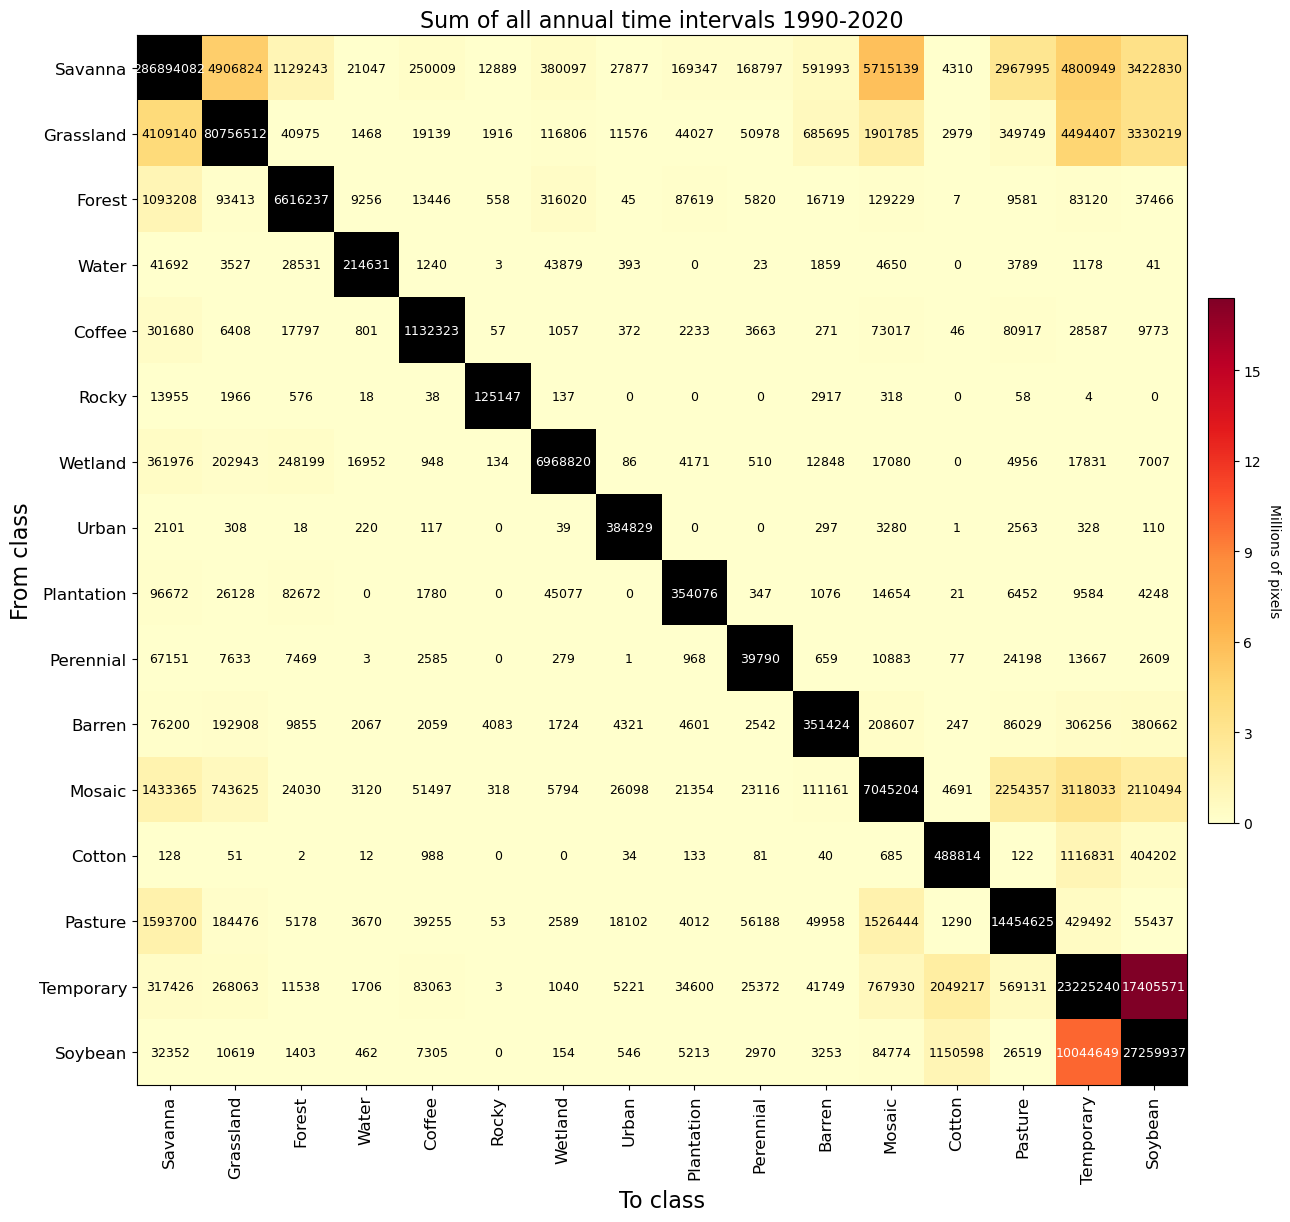

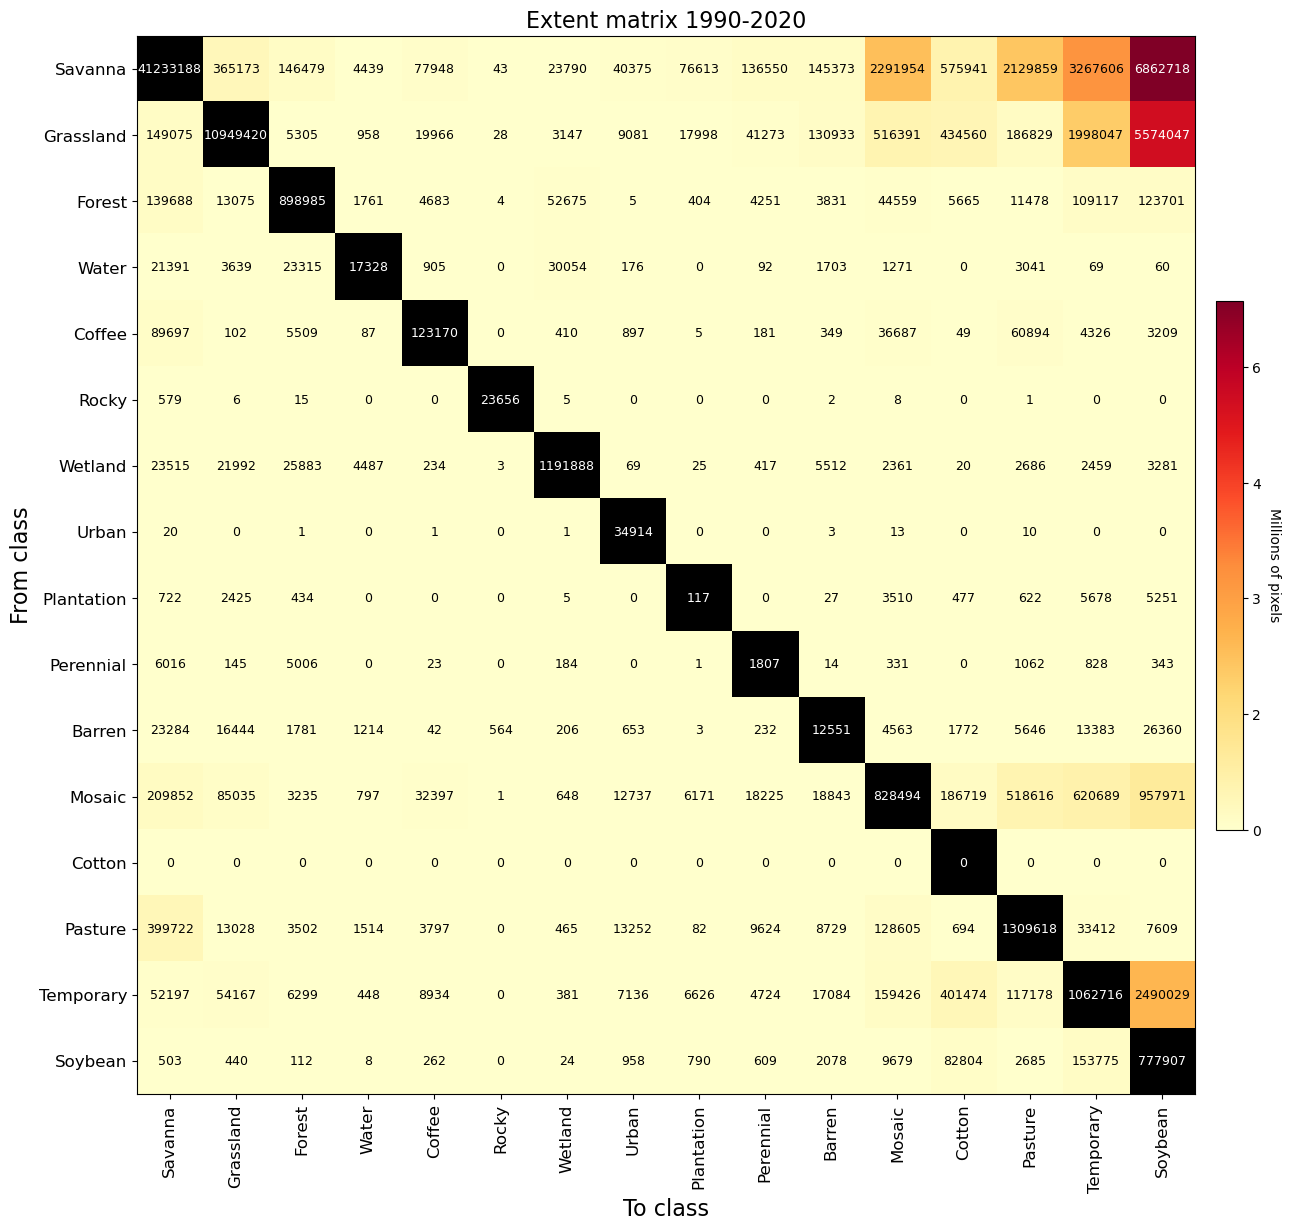

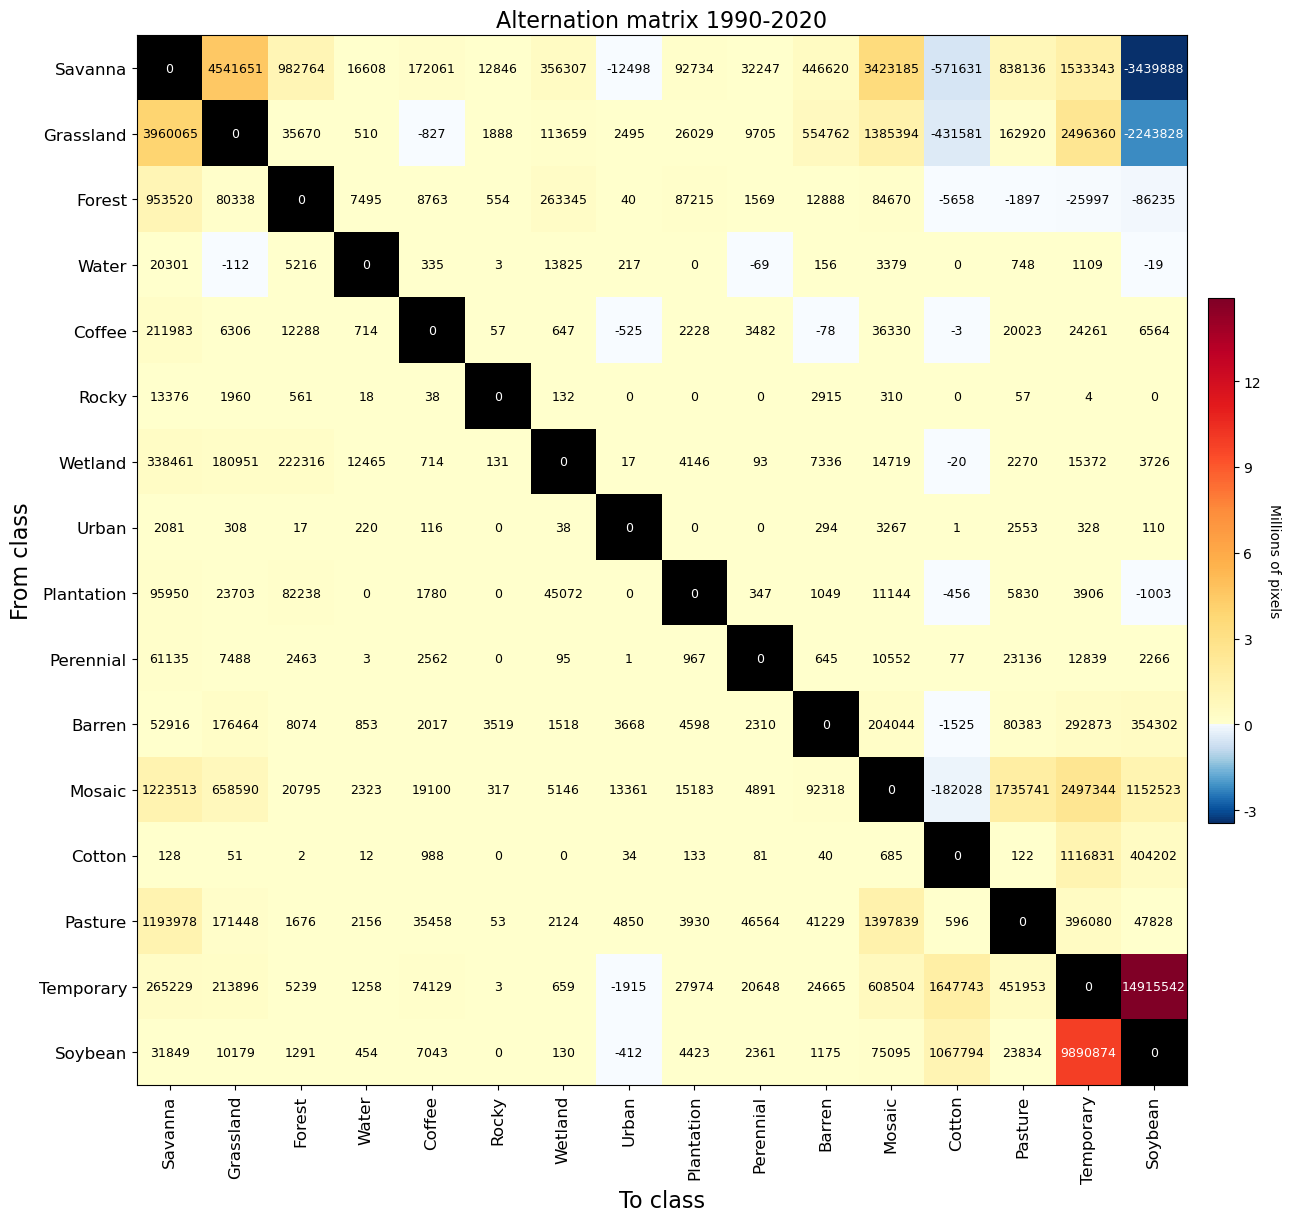

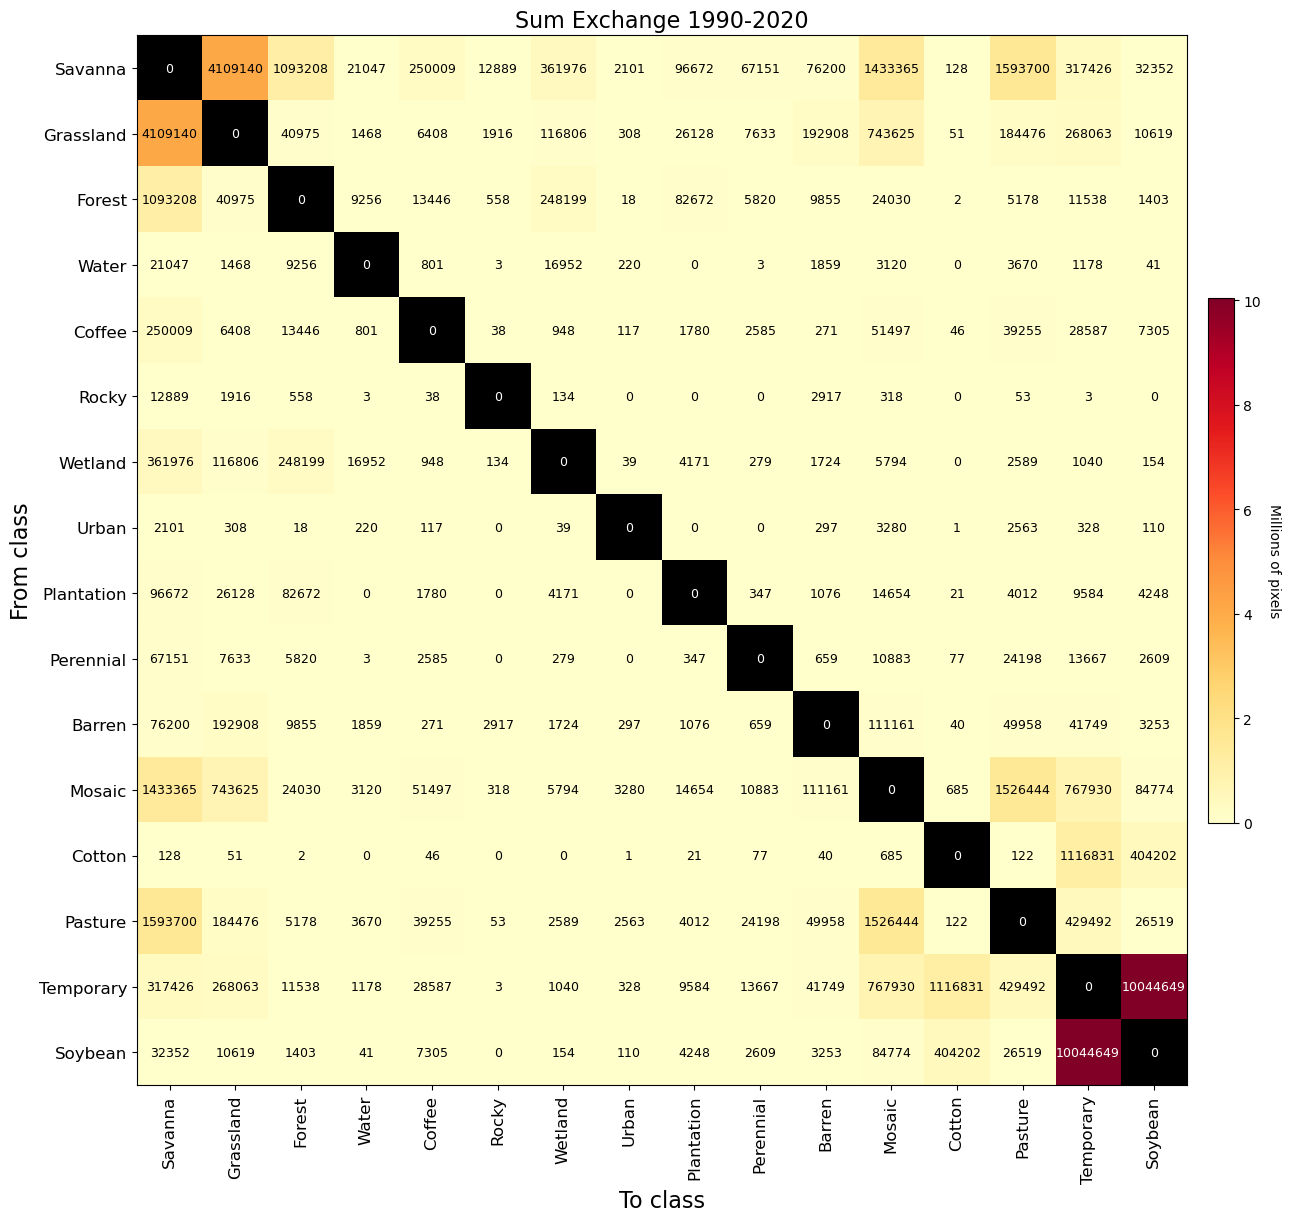

In [21]:
# %% [code]
# Paths for figures

FIG_SUM = OUT_DIR / f"heatmap_SUM_{Y0}-{Y1}.png"
FIG_EXT = OUT_DIR / f"heatmap_EXTENT_{Y0}-{Y1}.png"
FIG_ALT = OUT_DIR / f"heatmap_ALTERNATION_{Y0}-{Y1}.png"
FIG_EXC = OUT_DIR / f"heatmap_EXCHANGE_FROM_SUM_{Y0}-{Y1}.png"

# Plot:
#   - Sum, Extent, Alternation: diagonal replaced by zero for display
#   - Exchange: original diagonal
#   - All matrices scaled and labeled in millions of pixels

for df, title, path in [
    (
        df_sum_plot,
        f"Sum of all annual time intervals {Y0}-{Y1}",
        FIG_SUM,
    ),
    (
        df_ext_plot,
        f"Extent matrix {Y0}-{Y1}",
        FIG_EXT,
    ),
    (
        df_alt_plot,
        f"Alternation matrix {Y0}-{Y1}",
        FIG_ALT,
    ),
    (
        df_exc,
        f"Sum Exchange {Y0}-{Y1}",
        FIG_EXC,
    ),
]:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize=None,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=9,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )

## **5.Graphics**

---



### **5.1 Setting the parameters for the graphics**

In [ ]:
# Read change components CSV
csv_path = os.path.join(
    output_path,
    "change_components.csv",
)

# Validate path
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found: {csv_path}")

# Load into DataFrame
df = pd.read_csv(
    csv_path,
)

### **5.2 Change Components by Time Interval**

In [ ]:
# Filter only time intervals
time_df = df[
    df["Time_Interval"].str.contains("-")
]

# Aggregate totals per interval and component (Gain)
totals = (
    time_df.groupby(
        ["Time_Interval", "Component"]
    )["Gain"]
    .sum()
    .unstack()
)

# Print totals in million pixels
print("\nComponent Totals by Time Interval (million pixels):")
for index, row in totals.iterrows():
    print(f"\nTime Interval: {index}")
    for component in row.index:
        print(f"{component}: {row[component] / 1e6:.2f} M")

# Create figure and axis
fig, ax = plt.subplots(
    figsize=(14, 6),
)

# Colors
colors = [
    "#1f77b4",  # Quantity
    "#ffd700",  # Exchange
    "#2ca02c",  # Shift
]
components_color = {
    "Quantity": "#1f77b4",
    "Exchange": "#ffd700",
    "Shift": "#2ca02c",
}

# Stacked bars (Quantity, Exchange, Shift)
for idx, comp in enumerate(["Quantity", "Exchange", "Shift"]):
    bottom_values = (
        totals[["Quantity", "Exchange", "Shift"]]
        .iloc[:, :idx]
        .sum(axis=1)
        if idx > 0
        else 0
    )
    ax.bar(
        totals.index,
        totals[comp],
        label=comp,
        color=colors[idx],
        edgecolor="none",
        bottom=bottom_values,
    )

# Axes formatting
ax.set_ylabel(
    "Change (million pixels)",
    fontsize=18,
)
ax.set_title(
    "Change Components by Time Interval",
    fontsize=20,
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)
ax.yaxis.set_major_locator(
    ticker.MaxNLocator(integer=True)
)

# Y-axis in millions
def millions_formatter(x, pos):
    return f"{x / 1_000_000:.0f}"

ax.set_ylim(
    0,
    20_000_000,
)
ax.yaxis.set_major_locator(
    ticker.MultipleLocator(5_000_000)
)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(millions_formatter)
)

# Legend (custom labels)
legend_elements = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Shift"],
        label="Allocation Shift",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Exchange"],
        label="Allocation Exchange",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Quantity"],
        label="Quantity",
    ),
]
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    fontsize=16,
    frameon=False,
)

# Save and show
plt.tight_layout()
plt.savefig(
    os.path.join(
        output_path,
        "graphic_change_components_time_interval.jpeg",
    ),
    bbox_inches="tight",
    format="jpeg",
    dpi=300,
)
plt.show()

### **5.3 Change Components Overall**

In [ ]:
def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Stacked bar: Quantity (extent), Allocation Exchange/Shift, Alternation Exchange/Shift.
    """
    # Load data
    df = pd.read_csv(
        csv_path,
    )

    # Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }
    component_order = [
        "Quantity",
        "Allocation_Exchange",
        "Allocation_Shift",
        "Alternation_Exchange",
        "Alternation_Shift",
    ]

    # Totals per component (extent + alternation)
    component_totals = {
        "Quantity": df[
            (df["Component"] == "Quantity")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Exchange": df[
            (df["Component"] == "Allocation_Exchange")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Shift": df[
            (df["Component"] == "Allocation_Shift")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Alternation_Exchange": df[
            df["Component"] == "Alternation_Exchange"
        ]["Gain"].sum(),
        "Alternation_Shift": df[
            df["Component"] == "Alternation_Shift"
        ]["Gain"].sum(),
    }

    # Print totals (million pixels)
    print("\nComponent Totals (million pixels):")
    for comp, val in component_totals.items():
        print(f"{comp.replace('_', ' ')}: {val / 1_000_000:.2f} M")

    # Figure
    fig, ax = plt.subplots(
        figsize=(10, 6),
    )

    # Stacked bar (single x=0)
    bottom = 0
    bars = []
    labels = []
    for component in component_order:
        value = component_totals.get(component, 0)
        bar = ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor="none",
            width=1,
        )
        bars.append(bar[0])
        labels.append(component.replace("_", " "))
        bottom += value

    # Axes formatting
    ax.set_ylabel(
        "Change (millions pixels)",
        fontsize=16,
    )
    ax.set_title(
        "Change Components Overall",
        fontsize=18,
    )
    ax.xaxis.set_visible(False)
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=18,
    )

    # Y-axis in millions
    def millions_formatter(x, pos):
        return f"{x / 1_000_000:.0f}"

    ax.set_ylim(
        0,
        100_000_000,
    )
    ax.yaxis.set_major_locator(
        ticker.MultipleLocator(20_000_000)
    )
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(millions_formatter)
    )

    # Borders
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(True)

    # Legend (custom labels)
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Shift"],
            label="Alternation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Exchange"],
            label="Alternation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Shift"],
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Exchange"],
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Quantity"],
            label="Quantity",
        ),
    ]
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=14,
        frameon=False,
    )

    # Save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.jpeg",
        ),
        bbox_inches="tight",
        format="jpeg",
        dpi=300,
    )
    plt.show()


if __name__ == "__main__":
    csv_file = os.path.join(
        output_path,
        "change_components.csv",
    )
    plot_components_with_alternation(
        csv_file,
        output_path,
    )


### **5.4 Change Componentes by Class**

In [ ]:
class ComponentVisualizer:
    """Visualize components including alternation."""

    @staticmethod
    def plot_gain_loss_stacked(
        class_labels_dict: dict,
        title: str,
        output_path: str,
    ) -> None:
        """Plot gains and losses with alternation components."""
        # Globals used as in original code
        global df, components_color, component_order
        global figsize, title_fontsize, label_fontsize, tick_labelsize, legend_fontsize

        # Filter data
        filtered_df = df[
            df["Time_Interval"].isin(["extent", "alternation"])
        ]

        # Existing classes (exclude id 0)
        existing_classes = [
            cls for cls in filtered_df["Class"].unique() if cls != 0
        ]

        # Colors and component order (kept local as in original)
        components_color = {
            "Quantity": "#1f77b4",
            "Allocation_Exchange": "#ffd700",
            "Alternation_Exchange": "#ff8080",
            "Allocation_Shift": "#2ca02c",
            "Alternation_Shift": "#990099",
        }
        component_order = [
            "Quantity",
            "Allocation_Exchange",
            "Allocation_Shift",
            "Alternation_Exchange",
            "Alternation_Shift",
        ]

        # Sort classes by net quantity (gain - loss)
        class_totals = []
        for cls in existing_classes:
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            quantity_gain = class_data[
                class_data["Component"] == "Quantity"
            ]["Gain"].sum()
            quantity_loss = class_data[
                class_data["Component"] == "Quantity"
            ]["Loss"].sum()
            class_totals.append((cls, quantity_gain - quantity_loss))

        sorted_classes = sorted(
            class_totals,
            key=lambda x: x[1],
        )
        ordered_classes = [cls for cls, _ in sorted_classes]

        # Figure
        fig, ax = plt.subplots(
            figsize=(14, 8),
        )
        fig.subplots_adjust(
            left=0.1,
            right=0.75,
        )

        x_positions = np.arange(
            len(ordered_classes),
        )
        width = 0.8

        # Stacked bars per class (gains positive, losses negative)
        for idx, cls in enumerate(ordered_classes):
            class_data = filtered_df[
                filtered_df["Class"] == cls
            ]
            gain_bottom = 0
            loss_bottom = 0

            for comp in [
                "Quantity",
                "Allocation_Exchange",
                "Allocation_Shift",
                "Alternation_Exchange",
                "Alternation_Shift",
            ]:
                # Gains
                gains = class_data[
                    class_data["Component"] == comp
                ]["Gain"].sum()
                ax.bar(
                    x_positions[idx],
                    gains,
                    width,
                    bottom=gain_bottom,
                    color=components_color[comp],
                    edgecolor="none",
                )
                gain_bottom += gains

                # Losses (negative)
                losses = -class_data[
                    class_data["Component"] == comp
                ]["Loss"].sum()
                ax.bar(
                    x_positions[idx],
                    losses,
                    width,
                    bottom=loss_bottom,
                    color=components_color[comp],
                    edgecolor="none",
                )
                loss_bottom += losses

        # Axes formatting
        class_names = [
            class_labels_dict.get(cls, {}).get("rename", f"{cls}")
            for cls in ordered_classes
        ]
        ax.set_xticks(
            x_positions,
        )
        ax.set_xticklabels(
            class_names,
            rotation=45,
            ha="right",
            fontsize=18,
        )
        ax.axhline(
            0,
            color="black",
            linewidth=0.8,
        )
        ax.set_ylabel(
            "Change (millions pixels)",
            fontsize=16,
        )
        ax.set_title(
            title,
            fontsize=18,
        )
        ax.tick_params(
            axis="both",
            which="major",
            labelsize=18,
        )
        ax.yaxis.set_major_locator(
            ticker.MaxNLocator(integer=True)
        )

        # Y-axis in millions
        def millions_formatter(x, pos):
            return f"{x / 1_000_000:.0f}"

        ax.set_ylim(
            -30_000_000,
            30_000_000,
        )
        ax.yaxis.set_major_locator(
            ticker.MultipleLocator(5_000_000)
        )
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(millions_formatter)
        )

        # Legend
        legend_elements = [
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Alternation_Shift"],
                label="Alternation Shift",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Alternation_Exchange"],
                label="Alternation Exchange",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Allocation_Shift"],
                label="Allocation Shift",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Allocation_Exchange"],
                label="Allocation Exchange",
            ),
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_color["Quantity"],
                label="Quantity",
            ),
        ]
        ax.legend(
            handles=legend_elements,
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            fontsize=14,
            frameon=False,
        )

        # Save and show
        plt.tight_layout()
        plt.savefig(
            os.path.join(
                output_path,
                "graphic_change_component_change_class.jpeg",
            ),
            format="jpeg",
            dpi=300,
            bbox_inches="tight",
        )
        plt.show()


# Call
ComponentVisualizer.plot_gain_loss_stacked(
    class_labels_dict,
    "Change Components by Class",
    output_path,
)

## **6. Trajectory Classification**


---
### Overview
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 6.1 Number of Changes

In [ ]:
# Memory-efficient change count (vectorized + chunked)
import logging

# Logger (simple config)
logger = logging.getLogger("change_count")
if not logger.handlers:
    logging.basicConfig(level=logging.INFO)

# Params (configurable)
CHUNK_SIZE = 512          # rows per chunk
NODATA = 255              # nodata for output
BLOCK_SIZE = 256          # tiled block size

logger.info("Starting memory-efficient calculation of number of changes...")

# Output path
output_raster_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

# Template metadata
with rasterio.open(masked_image_paths[0]) as src:
    meta = src.meta.copy()
    height, width = src.shape

# Output metadata (tiled GeoTIFF)
meta.update(
    {
        "dtype": "uint8",
        "count": 1,
        "nodata": NODATA,
        "compress": "lzw",
        "tiled": True,
        "blockxsize": BLOCK_SIZE,
        "blockysize": BLOCK_SIZE,
    }
)

# Create output and process in chunks
with rasterio.open(
    output_raster_path,
    "w",
    **meta,
) as dst:
    logger.info(f"Output raster: {output_raster_path}")

    # Progress over chunks
    n_chunks = (height + CHUNK_SIZE - 1) // CHUNK_SIZE
    for y_start in tqdm(
        range(0, height, CHUNK_SIZE),
        total=n_chunks,
        desc="Chunks",
        unit="chunk",
    ):
        y_end = min(y_start + CHUNK_SIZE, height)
        chunk_h = y_end - y_start
        window = rasterio.windows.Window(0, y_start, width, chunk_h)

        # Read current chunk from each year
        chunk_stack = np.zeros(
            (len(masked_image_paths), chunk_h, width),
            dtype=np.uint8,
        )
        for i, path in enumerate(masked_image_paths):
            with rasterio.open(path) as src:
                chunk_stack[i] = src.read(
                    1,
                    window=window,
                )

        # Vectorized change count between consecutive rasters
        # Ignore transitions when previous state is background (0)
        transitions = (chunk_stack[1:] != chunk_stack[:-1]) & (chunk_stack[:-1] != 0)
        number_of_changes_chunk = np.sum(
            transitions,
            axis=0,
            dtype=np.uint8,
        )

        # Combined background mask (background in all dates)
        background_mask = np.all(
            chunk_stack == 0,
            axis=0,
        )
        number_of_changes_chunk[background_mask] = NODATA

        # Write chunk
        dst.write(
            number_of_changes_chunk,
            1,
            window=window,
        )

logger.info("Calculation complete. Raster saved.")

In [ ]:
# Plot "Number of Changes" map with DMS ticks and box legend

print("Generating map from 'number_of_changes.tif'...")

# 1) Input raster path
raster_to_plot_path = os.path.join(
    output_path,
    "number_of_changes.tif",
)

# 2) Read raster and basic metadata
with rasterio.open(raster_to_plot_path) as src:
    scale_factor = 0.15

    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    nodata_value = src.nodata
    if nodata_value is not None:
        data = np.ma.masked_equal(
            data,
            nodata_value,
        )

    left, bottom, right, top = src.bounds
    src_crs = src.crs.to_string()

# 3) Tick formatters (DMS)
transformer = Transformer.from_crs(
    src_crs,
    "EPSG:4326",
    always_xy=True,
)

def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bottom)
    deg = int(abs(lon))
    minutes = int((abs(lon) - deg) * 60)
    seconds = ((abs(lon) - deg) * 60 - minutes) * 60
    hemi = "E" if lon >= 0 else "W"
    return f"{deg}° {minutes}' {seconds:.1f}\"{hemi}"

def format_y_ticks(y, pos):
    _, lat = transformer.transform(left, y)
    deg = int(abs(lat))
    minutes = int((abs(lat) - deg) * 60)
    seconds = ((abs(lat) - deg) * 60 - minutes) * 60
    hemi = "N" if lat >= 0 else "S"
    return f"{deg}° {minutes}' {seconds:.1f}\"{hemi}"

# 4) Figure
fig, ax = plt.subplots(
    figsize=(10, 7),
    dpi=300,
)

# Data range
min_val = int(np.ma.min(data))
max_val = int(np.ma.max(data))

# 5) Colormap (gray for 0 + jet for 1..max)
original_cmap = plt.get_cmap(
    "jet",
)
color_list = ["#c0c0c0"] + [
    original_cmap(i) for i in np.linspace(0, 1, max_val)
]
cmap = ListedColormap(
    color_list,
)

# Discrete normalization
bounds = np.arange(
    min_val,
    max_val + 2,
) - 0.5
norm = BoundaryNorm(
    bounds,
    cmap.N,
)

# 6) Plot raster
ax.imshow(
    data,
    extent=[left, right, bottom, top],
    cmap=cmap,
    interpolation="none",
    norm=norm,
)

# 7) Discrete box legend
legend_elements = []
for i in range(min_val, max_val + 1):
    legend_elements.append(
        Patch(
            facecolor=cmap(norm(i)),
            edgecolor="black",
            linewidth=0.5,
            label=str(i),
        )
    )

ax.legend(
    handles=legend_elements,
    title="Number of Changes",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=12,
    title_fontsize=13,
    alignment="left",
)

# 8) Cartographic elements
scalebar = ScaleBar(
    1 / 1000,
    units="km",
    length_fraction=0.4,
    location="lower right",
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar,
)

north_arrow(
    ax,
    location="upper right",
    shadow=False,
    rotation={"degrees": 0},
)

# 9) Axes styling
ax.set_title(
    "Number of Changes",
    fontsize=18,
    pad=20,
)
ax.set_aspect(
    "equal",
)
ax.xaxis.set_major_formatter(
    FuncFormatter(format_x_ticks)
)
ax.yaxis.set_major_formatter(
    FuncFormatter(format_y_ticks)
)
ax.tick_params(
    axis="x",
    which="major",
    labelsize=7,
    pad=4,
)
ax.tick_params(
    axis="y",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(3)
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(6)
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)

# 10) Save
output_figure_path = os.path.join(
    output_path,
    "map_number_of_changes.png",
)
plt.savefig(
    output_figure_path,
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.5,
)
plt.show()

print(
    f"\nMap figure saved successfully to: {output_figure_path}"
)

### 6.2 Trajectory Analysis

This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [ ]:
# ── Trajectory classification + execution (single cell) ─────────────────────────

@nb.njit(nogil=True)
def classify_pixel(pixel_series):
    """Classify a pixel trajectory."""
    if pixel_series[0] == 0:
        return 0

    start = pixel_series[0]
    end = pixel_series[-1]

    has_variation = False
    direct_transition = False

    # Single pass over the series
    for i in range(len(pixel_series) - 1):
        current = pixel_series[i]
        next_val = pixel_series[i + 1]

        if not has_variation and current != next_val:
            has_variation = True

        if not direct_transition and current == start and next_val == end:
            direct_transition = True

    # 1) No change
    if not has_variation:
        return 1
    # 2) Changed but ended where started
    if start == end:
        return 2
    # 3) Direct transition start→end
    if direct_transition:
        return 3
    # 4) Other patterns
    return 4


@nb.njit(nogil=True, parallel=True)
def process_stack_parallel(stack, height, width):
    """Classify all pixels in parallel."""
    result = np.zeros((height, width), dtype=np.uint8)
    for y in prange(height):
        for x in range(width):
            result[y, x] = classify_pixel(stack[:, y, x])
    return result


class TrajectoryAnalyzer:
    @staticmethod
    def process_rasters(
        output_path,
        suffix="_masked.tif",
        chunk_size=500,
    ):
        """Process rasters in chunks and write 'trajectory.tif'."""
        os.makedirs(output_path, exist_ok=True)
        if not os.path.isdir(output_path):
            raise ValueError(f"Path must be a directory: {output_path}")

        raster_files = sorted(
            os.path.join(output_path, f)
            for f in os.listdir(output_path)
            if f.endswith(suffix)
        )
        if not raster_files:
            raise ValueError(f"No files found with suffix '{suffix}'")

        # Read shape and metadata from the first raster
        with rasterio.open(raster_files[0]) as src:
            meta = src.meta
            height, width = src.shape

        result = np.zeros((height, width), dtype=np.uint8)
        print(f"Starting processing of {height} rows in chunks of {chunk_size}...")

        # Row-wise chunking to limit memory
        for y_start in range(0, height, chunk_size):
            y_end = min(y_start + chunk_size, height)
            h = y_end - y_start

            stack = np.zeros((len(raster_files), h, width), dtype=np.uint8)
            for i, fpath in enumerate(raster_files):
                with rasterio.open(fpath) as src:
                    stack[i] = src.read(
                        1,
                        window=((y_start, y_end), (0, width)),
                    )

            result[y_start:y_end] = process_stack_parallel(stack, h, width)
            print(f"  > Processed rows {y_start}–{y_end}")

        # Save output
        meta.update(
            {
                "dtype": "uint8",
                "nodata": 0,
                "count": 1,
                "compress": "lzw",
            }
        )
        out_file = os.path.join(output_path, "trajectory.tif")
        with rasterio.open(out_file, "w", **meta) as dst:
            dst.write(result, 1)

        return out_file


# ── Run ────────────────────────────────────────────────────────────────────────
print("Starting trajectory analysis...")

trajectory_file = TrajectoryAnalyzer.process_rasters(
    output_path,
    suffix="_masked.tif",
    chunk_size=500,
)

print(f"\nProcessing complete! Results saved to: {trajectory_file}")


In [ ]:
def plot_trajectory_distribution(output_path: str) -> None:
    """
    Plot a stacked bar with the distribution of trajectory classes.
    Reads 'trajectory.tif' from output_path and saves a JPEG.
    """
    # Raster path
    raster_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    # Read raster
    with rasterio.open(raster_path) as src:
        traj_data = src.read(1)
        nodata = src.nodata

    # Mask NoData and count classes
    masked_traj = np.ma.masked_where(
        traj_data == nodata,
        traj_data,
    )
    unique, counts = np.unique(
        masked_traj.compressed(),
        return_counts=True,
    )
    total_pixels = counts.sum()

    # Percentages
    percentages = {
        k: (v / total_pixels) * 100.0
        for k, v in zip(unique, counts)
    }

    # Print table
    print("\nTrajectory Percentages:")
    for traj, pct in percentages.items():
        print(f"Trajectory {traj}: {pct:.2f}%")

    # Order and colors
    ordered_trajs = [4, 3, 2]
    colors = {
        4: "#000066",  # dark blue
        3: "#cccc00",  # gold
        2: "#990033",  # dark red
    }

    # Y-axis upper bound (nearest 10)
    max_percentage = sum(
        percentages.get(traj, 0.0) for traj in ordered_trajs
    )
    y_max = np.ceil(max_percentage / 10.0) * 10.0

    # Figure
    fig, ax = plt.subplots(
        figsize=(8, 6),
    )

    # Stacked bars (single category at x=0)
    bottom = 0.0
    for traj in ordered_trajs:
        if traj in percentages:
            ax.bar(
                0,
                percentages[traj],
                bottom=bottom,
                color=colors[traj],
                width=0.4,
                edgecolor="none",
            )
            bottom += percentages[traj]

    # Labels
    ax.set_ylabel(
        "Trajectory Area (% of western Bahia)",
        fontsize=16,
    )

    # Frame (all spines visible)
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color("black")
        ax.spines[spine].set_linewidth(0.5)

    # Ticks
    ax.tick_params(
        axis="y",
        which="minor",
        length=0,
    )
    ax.tick_params(
        axis="y",
        which="major",
        labelsize=18,
        length=6,
        width=1,
    )

    # Y scale
    ax.set_ylim(
        0,
        y_max,
    )
    ax.yaxis.set_major_locator(
        ticker.MultipleLocator(np.floor(y_max / 5.0))
    )

    # Hide x-axis
    ax.xaxis.set_visible(False)

    # No grid
    ax.grid(False)

    # Legend
    legend_elements = [
        Patch(facecolor=colors[4], label="Trajectory 4"),
        Patch(facecolor=colors[3], label="Trajectory 3"),
        Patch(facecolor=colors[2], label="Trajectory 2"),
    ]
    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        fontsize=14,
        frameon=False,
    )

    # Save
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "trajectory_distribution.jpeg",
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()


# Usage
if __name__ == "__main__":
    plot_trajectory_distribution(
        output_path,
    )

In [ ]:
# Plot trajectory map with DMS ticks, legend, north arrow, and scalebar

# Paths and basic params
raster_path = os.path.join(
    output_path,
    "trajectory.tif",
)
dpi = 300
scale_factor = 0.15

# Legend elements
legend_elements = [
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#d9d9d9",
        label="1:Start class matches end class while\nalternation = 0",
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#990033",
        label="2:Start class matches end class while\nalternation > 0",
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#cccc00",
        label="3:Start class differs from end class while\nat least one time interval transitions from\nstart class to end class",
    ),
    Rectangle(
        (0, 0),
        1,
        1,
        facecolor="#000066",
        label="4:Start class differs from end class while\nno time interval transitions from start\nclass to end class",
    ),
]

# Colormap
cmap = ListedColormap(
    [
        "#ffffff",
        "#d9d9d9",
        "#990033",
        "#cccc00",
        "#000066",
    ]
)

with rasterio.open(raster_path) as src:
    # Read and downsample (nearest: categorical)
    data = src.read(
        1,
        out_shape=(
            int(src.height * scale_factor),
            int(src.width * scale_factor),
        ),
        resampling=rasterio.enums.Resampling.nearest,
    )

    # Bounds and CRS
    left, bottom, right, top = src.bounds
    src_crs = src.crs.to_string()

# Transformer and tick formatters (DMS)
transformer = Transformer.from_crs(
    src_crs,
    "EPSG:4326",
    always_xy=True,
)

def format_x_ticks(x, pos):
    lon, _ = transformer.transform(x, bottom)
    deg = int(abs(lon))
    minutes = int((abs(lon) - deg) * 60)
    seconds = ((abs(lon) - deg) * 60 - minutes) * 60
    hemi = "E" if lon >= 0 else "W"
    return f"{deg}° {minutes}' {seconds:.2f}\"{hemi}"

def format_y_ticks(y, pos):
    _, lat = transformer.transform(left, y)
    deg = int(abs(lat))
    minutes = int((abs(lat) - deg) * 60)
    seconds = ((abs(lat) - deg) * 60 - minutes) * 60
    hemi = "N" if lat >= 0 else "S"
    return f"{deg}° {minutes}' {seconds:.2f}\"{hemi}"

# Figure
fig, ax = plt.subplots(
    figsize=(14, 8),
    dpi=dpi,
)

# Raster plot
ax.imshow(
    data,
    cmap=cmap,
    extent=[left, right, bottom, top],
    interpolation="none",
)

# Ticks
ax.xaxis.set_major_formatter(
    FuncFormatter(format_x_ticks)
)
ax.yaxis.set_major_formatter(
    FuncFormatter(format_y_ticks)
)

# Scalebar (km)
scalebar = ScaleBar(
    1 / 1000,
    units="km",
    length_fraction=0.4,
    location="lower right",
    scale_formatter=lambda value, _: f"{int(value)} km",
)
ax.add_artist(
    scalebar
)

# North arrow
north_arrow(
    ax,
    location="upper right",
    shadow=False,
    rotation={"degrees": 0},
)

# Style
ax.set_aspect(
    "equal",
)
ax.tick_params(
    axis="x",
    which="major",
    labelsize=7,
    pad=4,
)
ax.tick_params(
    axis="y",
    which="major",
    labelsize=7,
    pad=4,
)
ax.xaxis.set_major_locator(
    plt.MaxNLocator(3)
)
ax.yaxis.set_major_locator(
    plt.MaxNLocator(6)
)
plt.setp(
    ax.get_yticklabels(),
    rotation=90,
    va="center",
)
plt.title(
    "Trajectories",
    fontsize=18,
    pad=20,
)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_horizontalalignment("center")
    label.set_verticalalignment("center")

# Legend
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    fontsize=12,
    borderpad=1.2,
    handletextpad=0.8,
    columnspacing=2,
)

# Save
plt.savefig(
    os.path.join(
        output_path,
        "map_trajectories_degree.jpeg",
    ),
    dpi=dpi,
    bbox_inches="tight",
    pad_inches=0.5,
    pil_kwargs={"optimize": True, "quality": 95},
)
plt.show()
plt.close()

print(
    "Map saved successfully in the folder:",
    output_path,
)